In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Tạo file csv


**Mục đích: Tự động sinh file CSV chứa nhãn ảnh (real/fake) từ thư mục dữ liệu.**

**Mô tả:**
**- Quét toàn bộ ảnh trong các thư mục train, val, test.**
**- Xác định class dựa vào tên file (ví dụ: 'ffhq_1.jpg' → class 'ffhq').**
**- Gán nhãn 'real' hoặc 'fake' dựa trên danh sách class có sẵn.**
**- Xuất ra file CSV với 3 cột: image_path, label, class_name.**

**Kết quả:**
    **train_label.csv**
    **val_label.csv**
    **test_label.csv**

In [ ]:
# Khai báo thư viện 
import os
import pandas as pd

# Danh sách các class
REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
   "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

ALL_CLASSES = REAL_CLASSES + FAKE_CLASSES

# Nhận diện class từ tên file
def identify_class(filename):
    filename_lower = filename.lower()
    for method in ALL_CLASSES:
        if filename_lower.startswith(method):
            return method
    return None  # Không xác định class

# Tạo file CSV từ thư mục ảnh
def generate_csv_from_flat_folder(folder_path, output_csv):
    image_paths = []
    labels = []
    class_names = []

    if not os.path.exists(folder_path):
        print(f"❌ Không tìm thấy thư mục: {folder_path}")
        return

    print(f"🔍 Đang xử lý: {folder_path}")

    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
            class_name = identify_class(img_file)
            if class_name is None:
                print(f"[!] ⚠️ Bỏ qua ảnh không xác định class: {img_file}")
                continue

            label = "real" if class_name in REAL_CLASSES else "fake"
            full_path = os.path.join(folder_path, img_file)
            image_paths.append(full_path)
            labels.append(label)
            class_names.append(class_name)

    # Tạo DataFrame và lưu
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'class_name': class_names
    })
    df.to_csv(output_csv, index=False)
    print(f"✅ Đã tạo {output_csv} với {len(df)} ảnh.")

# Đường dẫn thư mục (cần điều chỉnh nếu bạn chạy trên môi trường khác)
train_dir = "/kaggle/input/dataset-artifact/do_an_tot_nghiep/train"
val_dir = "/kaggle/input/dataset-artifact/do_an_tot_nghiep/val"
test_dir = "/kaggle/input/dataset-artifact/do_an_tot_nghiep/test"
# Tạo file CSV cho các tập
generate_csv_from_flat_folder(train_dir, "train_label.csv")
generate_csv_from_flat_folder(val_dir, "val_label.csv")
generate_csv_from_flat_folder(test_dir, "test_label.csv")

# Huấn luyện mô hình Dual-Stream EfficientNet-B3, kết hợp miền không gian (spatial) và miền tần số (frequency domain) của ảnh để phát hiện ảnh sinh bởi các mô hình GAN/Diffusion.

**Mục đích: Huấn luyện mô hình Dual-Stream EfficientNet-B3 để phân loại ảnh thật/giả và nhận diện mô hình sinh ảnh giả (GAN/Diffusion).**

**Cấu trúc:**

**- Nhánh 1 (Spatial): xử lý ảnh RGB gốc.**

**- Nhánh 2 (Frequency): xử lý ảnh trong miền tần số Fourier.**

**- Hai nhánh được kết hợp (fusion) và chia ra:**

**+ Binary head: phân biệt real/fake.**

**+ Multi-class head: phân loại loại ảnh giả (10 FAKE_CLASSES).**

**Đặc điểm:**
**- Sử dụng EfficientNet-B3 pretrained từ timm.**

**- Huấn luyện bằng mixed precision (torch.amp).**

**- Có early stopping và lưu checkpoint/best model.**

**- Đọc dữ liệu từ CSV.**

**Kết quả:**

**- Tệp model tốt nhất: best_model.pth**

**- Tệp log/report: in ra classification report cho binary & multi-class.**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# Constants
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5  # early stopping patience

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_BINARY_CLASSES = 2
NUM_FAKE_CLASSES = 10  # Chỉ 12 lớp fake
TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
 "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}  # Chỉ map cho fake classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")

        # spatial
        img_spatial = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # frequency
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        # Multi-class label: Chỉ cho fake, ignore cho real
        if binary_label == 0:  # real
            multi_label = -100  # Ignore index
        else:  # fake
            if class_name in self.class_map:
                multi_label = self.class_map[class_name]
            else:
                multi_label = -100  # Fallback nếu class_name không match

        return img_spatial, img_freq, binary_label, multi_label

# ========================
# Data transforms
# ========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = ImageDataset(VAL_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# Model (Dual-Stream EfficientNet-B3)
# ========================
class DualStreamEffNetB3(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super(DualStreamEffNetB3, self).__init__()
        # spatial branch
        self.spatial_cnn = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        # frequency branch
        self.freq_cnn = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        # feature dimension
        self.feature_dim = self.spatial_cnn.num_features
        # fusion layer
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)
        # classification heads
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)  # Chỉ 12 fake classes

    def forward(self, spatial_x, freq_x):
        spatial_features = self.spatial_cnn(spatial_x)
        freq_features = self.freq_cnn(freq_x)
        combined = torch.cat((spatial_features, freq_features), dim=1)
        fused = torch.relu(self.fusion(combined))
        binary_out = self.binary_head(fused)
        multi_class_out = self.multi_class_head(fused)
        return binary_out, multi_class_out

# ========================
# Training & Validation
# ========================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    total_samples = 0

    loop = tqdm(loader, desc="Training", leave=False)
    for spatial_x, freq_x, binary_y, multi_y in loop:
        spatial_x, freq_x, binary_y, multi_y = (
            spatial_x.to(DEVICE), freq_x.to(DEVICE),
            binary_y.to(DEVICE), multi_y.to(DEVICE)
        )

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Updated to new API
            binary_out, multi_class_out = model(spatial_x, freq_x)
            binary_loss = binary_criterion(binary_out, binary_y)

            # Multi-class loss chỉ tính cho fake samples (multi_y != -100)
            multi_class_loss = multi_class_criterion(multi_class_out, multi_y) if multi_y.numel() > 0 and multi_y[0] != -100 else torch.tensor(0.0, device=DEVICE)

            loss = binary_loss + multi_class_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * spatial_x.size(0)
        total_samples += spatial_x.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / total_samples

def validate(model, loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    all_binary_preds, all_binary_labels = [], []
    all_multi_preds, all_multi_labels = [], []  # Chỉ collect cho fake
    with torch.no_grad():
        loop = tqdm(loader, desc="Validating", leave=False)
        for spatial_x, freq_x, binary_y, multi_y in loop:
            spatial_x, freq_x, binary_y, multi_y = (
                spatial_x.to(DEVICE), freq_x.to(DEVICE),
                binary_y.to(DEVICE), multi_y.to(DEVICE)
            )
            with torch.amp.autocast('cuda'):  # Updated to new API
                binary_out, multi_class_out = model(spatial_x, freq_x)
                binary_loss = binary_criterion(binary_out, binary_y)

                # Multi-class loss chỉ cho fake
                multi_class_loss = multi_class_criterion(multi_class_out, multi_y) if multi_y.numel() > 0 and multi_y[0] != -100 else torch.tensor(0.0, device=DEVICE)

                loss = binary_loss + multi_class_loss

            total_loss += loss.item() * spatial_x.size(0)
            total_samples += spatial_x.size(0)
            # collect preds
            all_binary_preds.extend(binary_out.argmax(1).cpu().numpy())
            all_binary_labels.extend(binary_y.cpu().numpy())

            # Chỉ collect multi-class cho fake samples (binary_y == 1)
            fake_mask = (binary_y == 1).cpu().numpy()
            fake_preds = multi_class_out.argmax(1).cpu().numpy()[fake_mask]
            fake_labels = multi_y.cpu().numpy()[fake_mask]
            # Lọc bỏ -100 nếu có
            valid_fake_labels = [lbl for lbl in fake_labels if lbl != -100]
            valid_fake_preds = fake_preds[:len(valid_fake_labels)]  # Align

            all_multi_preds.extend(valid_fake_preds)
            all_multi_labels.extend(valid_fake_labels)

            loop.set_postfix(loss=loss.item())
    avg_loss = total_loss / total_samples

    # reports
    print("\n=== Binary Classification (real vs fake) ===")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"]))

    if all_multi_labels:  # Chỉ print nếu có fake samples
        print("\n=== Multi-class Classification (10 fake classes) ===")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES))
    else:
        print("\n=== Multi-class Classification (10 fake classes) ===\nNo fake samples in validation.")

    return avg_loss

# ========================
# Run training with early stopping
# ========================
model = DualStreamEffNetB3(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
binary_criterion = nn.CrossEntropyLoss()
multi_class_criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore -100 cho real
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")

    train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss = validate(model, val_loader)
    print(f"Val Loss: {val_loss:.4f}")

    # save checkpoint every epoch
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, checkpoint_path)
    print(f"💾 Saved {checkpoint_path}")

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model improved, saved as best_model.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered!")
            break
    scheduler.step()

# Huấn luyện mô hình Dual-Stream ViT-Small (Vision Transformer)

**Mục đích: Huấn luyện mô hình Dual-Stream ViT-Small để phân loại ảnh thật/giả và nhận diện mô hình sinh ảnh giả (GAN/Diffusion).**

**Cấu trúc:**

**- Nhánh 1 (Spatial): ViT-Small xử lý ảnh RGB.**

**- Nhánh 2 (Frequency): ViT-Small xử lý phổ tần Fourier của ảnh.**

**- Hai nhánh được kết hợp (fusion) và chia ra:**

**+ Binary head: phân biệt real/fake.**

**+ Multi-class head: phân loại loại ảnh giả (10 FAKE_CLASSES).**

**Đặc điểm:**
**- Sử dụng ViT-Small pretrained từ timm.**

**- Huấn luyện bằng mixed precision (torch.amp).**

**- Có early stopping và lưu checkpoint/best model.**

**- Đọc dữ liệu từ CSV.**

**Kết quả:**

**- Tệp model tốt nhất: best_model.pth**

**- Tệp log/report: in ra classification report cho binary & multi-class.**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# Constants
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5  # early stopping patience

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_BINARY_CLASSES = 2
NUM_FAKE_CLASSES = 10  # Chỉ 12 lớp fake
TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
   "latent_diffusion",  "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}  # Chỉ map cho fake classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")

        # spatial
        img_spatial = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # frequency
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        # Multi-class label: Chỉ cho fake, ignore cho real
        if binary_label == 0:  # real
            multi_label = -100  # Ignore index
        else:  # fake
            if class_name in self.class_map:
                multi_label = self.class_map[class_name]
            else:
                multi_label = -100  # Fallback nếu class_name không match

        return img_spatial, img_freq, binary_label, multi_label

# ========================
# Data transforms
# ========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = ImageDataset(VAL_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# Model (Dual-Stream ViT-Small)
# ========================
class DualStreamViTSmall(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super(DualStreamViTSmall, self).__init__()
        # spatial branch
        self.spatial_cnn = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        # frequency branch
        self.freq_cnn = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        # feature dimension
        self.feature_dim = self.spatial_cnn.num_features
        # fusion layer
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)
        # classification heads
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes) 

    def forward(self, spatial_x, freq_x):
        spatial_features = self.spatial_cnn(spatial_x)
        freq_features = self.freq_cnn(freq_x)
        combined = torch.cat((spatial_features, freq_features), dim=1)
        fused = torch.relu(self.fusion(combined))
        binary_out = self.binary_head(fused)
        multi_class_out = self.multi_class_head(fused)
        return binary_out, multi_class_out

# ========================
# Training & Validation
# ========================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0
    total_samples = 0

    loop = tqdm(loader, desc="Training", leave=False)
    for spatial_x, freq_x, binary_y, multi_y in loop:
        spatial_x, freq_x, binary_y, multi_y = (
            spatial_x.to(DEVICE), freq_x.to(DEVICE),
            binary_y.to(DEVICE), multi_y.to(DEVICE)
        )

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Updated to new API
            binary_out, multi_class_out = model(spatial_x, freq_x)
            binary_loss = binary_criterion(binary_out, binary_y)

            # Multi-class loss chỉ tính cho fake samples (multi_y != -100)
            multi_class_loss = multi_class_criterion(multi_class_out, multi_y) if multi_y.numel() > 0 and multi_y[0] != -100 else torch.tensor(0.0, device=DEVICE)

            loss = binary_loss + multi_class_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * spatial_x.size(0)
        total_samples += spatial_x.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / total_samples

def validate(model, loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    all_binary_preds, all_binary_labels = [], []
    all_multi_preds, all_multi_labels = [], []  # Chỉ collect cho fake
    with torch.no_grad():
        loop = tqdm(loader, desc="Validating", leave=False)
        for spatial_x, freq_x, binary_y, multi_y in loop:
            spatial_x, freq_x, binary_y, multi_y = (
                spatial_x.to(DEVICE), freq_x.to(DEVICE),
                binary_y.to(DEVICE), multi_y.to(DEVICE)
            )
            with torch.amp.autocast('cuda'):  # Updated to new API
                binary_out, multi_class_out = model(spatial_x, freq_x)
                binary_loss = binary_criterion(binary_out, binary_y)

                # Multi-class loss chỉ cho fake
                multi_class_loss = multi_class_criterion(multi_class_out, multi_y) if multi_y.numel() > 0 and multi_y[0] != -100 else torch.tensor(0.0, device=DEVICE)

                loss = binary_loss + multi_class_loss

            total_loss += loss.item() * spatial_x.size(0)
            total_samples += spatial_x.size(0)
            # collect preds
            all_binary_preds.extend(binary_out.argmax(1).cpu().numpy())
            all_binary_labels.extend(binary_y.cpu().numpy())

            # Chỉ collect multi-class cho fake samples (binary_y == 1)
            fake_mask = (binary_y == 1).cpu().numpy()
            fake_preds = multi_class_out.argmax(1).cpu().numpy()[fake_mask]
            fake_labels = multi_y.cpu().numpy()[fake_mask]
            # Lọc bỏ -100 nếu có
            valid_fake_labels = [lbl for lbl in fake_labels if lbl != -100]
            valid_fake_preds = fake_preds[:len(valid_fake_labels)]  # Align

            all_multi_preds.extend(valid_fake_preds)
            all_multi_labels.extend(valid_fake_labels)

            loop.set_postfix(loss=loss.item())
    avg_loss = total_loss / total_samples

    # reports
    print("\n=== Binary Classification (real vs fake) ===")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"]))

    if all_multi_labels:  # Chỉ print nếu có fake samples
        print("\n=== Multi-class Classification (12 fake classes) ===")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES))
    else:
        print("\n=== Multi-class Classification (12 fake classes) ===\nNo fake samples in validation.")

    return avg_loss

# ========================
# Run training with early stopping
# ========================
model = DualStreamViTSmall(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
binary_criterion = nn.CrossEntropyLoss()
multi_class_criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore -100 cho real
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")

    train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    print(f"Train Loss: {train_loss:.4f}")

    val_loss = validate(model, val_loader)
    print(f"Val Loss: {val_loss:.4f}")

    # save checkpoint every epoch
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        "epoch_ViT": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, checkpoint_path)
    print(f"💾 Saved {checkpoint_path}")

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model improved, saved as best_model.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered!")
            break
    scheduler.step()

# Huấn luyện mô hình Dual-Stream Resnet50

**Mục đích: Huấn luyện mô hình Dual-Stream Resnet50 để phân loại ảnh thật/giả và nhận diện mô hình sinh ảnh giả (GAN/Diffusion).**

**Cấu trúc:**

**- Nhánh 1 (Spatial): xử lý ảnh RGB gốc.**

**- Nhánh 2 (Frequency): xử lý ảnh trong miền tần số Fourier.**

**- Hai nhánh được kết hợp (fusion) và chia ra:**

**+ Binary head: phân biệt real/fake.**

**+ Multi-class head: phân loại loại ảnh giả (10 FAKE_CLASSES).**

**Đặc điểm:**

**- Sử dụng Resnet50 pretrained từ timm.**

**- Huấn luyện bằng mixed precision (torch.amp).**

**- Có early stopping và lưu checkpoint/best model.**

**- Đọc dữ liệu từ CSV.**

**Kết quả:**

**- Tệp model tốt nhất: best_model.pth**

**- Tệp log/report: in ra classification report cho binary & multi-class.**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# Constants
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5  # early stopping patience

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_BINARY_CLASSES = 2
NUM_FAKE_CLASSES = 10  # Chỉ 12 lớp fake
TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
   "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}  # Chỉ map cho fake classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")

        # spatial
        img_spatial = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # frequency
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        # Multi-class label: Chỉ cho fake, ignore cho real
        if binary_label == 0:  # real
            multi_label = -100  # Ignore index
        else:  # fake
            if class_name in self.class_map:
                multi_label = self.class_map[class_name]
            else:
                multi_label = -100  # fallback

        return img_spatial, img_freq, binary_label, multi_label

# ========================
# Data transforms
# ========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = ImageDataset(VAL_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# Model (Dual-Stream ResNet50)
# ========================
class DualStreamResNet50(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super(DualStreamResNet50, self).__init__()
        self.spatial_cnn = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.freq_cnn = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        spatial_features = self.spatial_cnn(spatial_x)
        freq_features = self.freq_cnn(freq_x)
        combined = torch.cat((spatial_features, freq_features), dim=1)
        fused = torch.relu(self.fusion(combined))
        binary_out = self.binary_head(fused)
        multi_class_out = self.multi_class_head(fused)
        return binary_out, multi_class_out

# ========================
# Evaluation function
# ========================
def evaluate(model, loader, desc="Evaluating"):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_binary_preds, all_binary_labels = [], []
    all_multi_preds, all_multi_labels = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=desc, leave=False)
        for spatial_x, freq_x, binary_y, multi_y in loop:
            spatial_x, freq_x, binary_y, multi_y = (
                spatial_x.to(DEVICE), freq_x.to(DEVICE),
                binary_y.to(DEVICE), multi_y.to(DEVICE)
            )
            with torch.amp.autocast('cuda'):
                binary_out, multi_class_out = model(spatial_x, freq_x)
                binary_loss = binary_criterion(binary_out, binary_y)
                multi_class_loss = multi_class_criterion(multi_class_out, multi_y) if multi_y.numel() > 0 and multi_y[0] != -100 else torch.tensor(0.0, device=DEVICE)
                loss = binary_loss + multi_class_loss

            total_loss += loss.item() * spatial_x.size(0)
            total_samples += spatial_x.size(0)

            all_binary_preds.extend(binary_out.argmax(1).cpu().numpy())
            all_binary_labels.extend(binary_y.cpu().numpy())

            fake_mask = (binary_y == 1).cpu().numpy()
            fake_preds = multi_class_out.argmax(1).cpu().numpy()[fake_mask]
            fake_labels = multi_y.cpu().numpy()[fake_mask]
            valid_fake_labels = [lbl for lbl in fake_labels if lbl != -100]
            valid_fake_preds = fake_preds[:len(valid_fake_labels)]
            all_multi_preds.extend(valid_fake_preds)
            all_multi_labels.extend(valid_fake_labels)

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_samples

    print(f"\n=== Binary Classification (real vs fake) ===")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"]))

    if all_multi_labels:
        print(f"\n=== Multi-class Classification (10 fake classes) ===")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES))
    else:
        print(f"\n=== Multi-class Classification (10 fake classes) ===\nNo fake samples.")

    return avg_loss

# ========================
# Training loop (val only)
# ========================
model = DualStreamResNet50(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
binary_criterion = nn.CrossEntropyLoss()
multi_class_criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")

    model.train()
    total_loss = 0
    total_samples = 0
    loop = tqdm(train_loader, desc="Training", leave=False)
    for spatial_x, freq_x, binary_y, multi_y in loop:
        spatial_x, freq_x, binary_y, multi_y = (
            spatial_x.to(DEVICE), freq_x.to(DEVICE),
            binary_y.to(DEVICE), multi_y.to(DEVICE)
        )

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            binary_out, multi_class_out = model(spatial_x, freq_x)
            binary_loss = binary_criterion(binary_out, binary_y)
            multi_class_loss = multi_class_criterion(multi_class_out, multi_y) if multi_y.numel() > 0 and multi_y[0] != -100 else torch.tensor(0.0, device=DEVICE)
            loss = binary_loss + multi_class_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * spatial_x.size(0)
        total_samples += spatial_x.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / total_samples
    print(f"Train Loss: {train_loss:.4f}")

    # 👉 Chỉ đánh giá trên tập validation
    val_loss = evaluate(model, val_loader, desc="Validating")
    print(f"Val Loss: {val_loss:.4f}")

    # Lưu checkpoint
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        "epochresnet": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, checkpoint_path)
    print(f"💾 Saved {checkpoint_path}")

    # Lưu best model theo val loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model improved, saved as best_model.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered!")
            break
    scheduler.step()

# Huấn luyện mô hình EfficientNetB3 trên miền tần số 

**Ý tưởng:**

 
**- Thay vì kết hợp miền không gian và miền tần số, thì mô hình này làm việc     chỉ trên miền tần số (frequency domain) bằng cách áp dụng FFT.**

     
   **- Sử dụng backbone EfficientNet-B3 (pretrained trên ImageNet).**
   
   **- Mô hình có 2 đầu ra (multi-head):**
   
   **+ Binary: Phân loại Real vs Fake.**
   
   **+ Multi-class: Phân loại 10 loại ảnh Fake khác nhau.**
       

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np

# ========================
# Constants
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"
TEST_CSV = "test_label.csv"

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Frequency Transform
# ========================
class FFTTransform:
    """Chuyển ảnh RGB sang miền tần số (biên độ phổ log scale)"""
    def __call__(self, img):
        img_np = np.array(img) / 255.0  # [0, 1]
        freq_channels = []
        for c in range(3):
            f = np.fft.fft2(img_np[..., c])
            fshift = np.fft.fftshift(f)
            magnitude = np.log(np.abs(fshift) + 1e-8)
            magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-8)
            freq_channels.append(magnitude)
        freq_img = np.stack(freq_channels, axis=-1)
        freq_img = (freq_img * 255).astype(np.uint8)
        return Image.fromarray(freq_img)

# ========================
# Dataset
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, use_frequency=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.use_frequency = use_frequency
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}
        self.fft = FFTTransform()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")
        if self.use_frequency:
            img = self.fft(img)
        img = self.transform(img) if self.transform else transforms.ToTensor()(img)

        if label == 0:
            multi_label = -100
        else:
            multi_label = self.class_map.get(class_name, -100)

        return img, label, multi_label


# ========================
# DataLoader
# ========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_loader = DataLoader(ImageDataset(TRAIN_CSV, train_transform, use_frequency=True),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(ImageDataset(VAL_CSV, val_test_transform, use_frequency=True),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(ImageDataset(TEST_CSV, val_test_transform, use_frequency=True),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# ========================
# Model
# ========================
class FrequencyEffNetB3_MultiHead(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, x):
        features = self.backbone(x)
        binary_out = self.binary_head(features)
        multi_out = self.multi_head(features)
        return binary_out, multi_out


# ========================
# Evaluation
# ========================
def evaluate(model, loader, phase="Validation"):
    model.eval()
    all_binary_preds, all_binary_labels = [], []
    all_multi_preds, all_multi_labels = [], []

    with torch.no_grad():
        for x, binary_y, multi_y in loader:
            x, binary_y, multi_y = x.to(DEVICE), binary_y.to(DEVICE), multi_y.to(DEVICE)
            binary_out, multi_out = model(x)

            binary_preds = binary_out.argmax(1)
            all_binary_preds.extend(binary_preds.cpu().numpy())
            all_binary_labels.extend(binary_y.cpu().numpy())

            mask = (binary_y == 1)
            if mask.any():
                multi_preds = multi_out[mask].argmax(1).cpu().numpy()
                multi_labels = multi_y[mask].cpu().numpy()
                valid_mask = multi_labels != -100
                all_multi_preds.extend(multi_preds[valid_mask])
                all_multi_labels.extend(multi_labels[valid_mask])

    # ===== Binary =====
    print(f"\n📊 {phase} - Binary Classification (Real vs Fake)")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"]))
    cm_bin = confusion_matrix(all_binary_labels, all_binary_preds)
    sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{phase} Confusion Matrix - Binary")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(all_binary_labels, all_binary_preds)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f"{phase}").plot()
    plt.show()
    print(f"{phase} Binary ROC-AUC: {roc_auc:.4f}")

    # ===== Multi-class =====
    if len(all_multi_labels) > 0:
        print(f"\n📊 {phase} - Multi-class Classification (10 Fake Classes)")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES))
        cm_multi = confusion_matrix(all_multi_labels, all_multi_preds)
        sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Greens',
                    xticklabels=FAKE_CLASSES, yticklabels=FAKE_CLASSES)
        plt.title(f"{phase} Confusion Matrix - Multi-class")
        plt.show()


# ========================
# Training
# ========================
def train(model, train_loader, val_loader, test_loader, epochs=NUM_EPOCHS):
    binary_criterion = nn.CrossEntropyLoss()
    multi_criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float("inf")
    patience = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for x, binary_y, multi_y in pbar:
            x, binary_y, multi_y = x.to(DEVICE), binary_y.to(DEVICE), multi_y.to(DEVICE)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                binary_out, multi_out = model(x)
                binary_loss = binary_criterion(binary_out, binary_y)
                multi_loss = multi_criterion(multi_out, multi_y)
                loss = binary_loss + multi_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

        # Đánh giá sau mỗi epoch
        print("\n--- EVALUATION ---")
        evaluate(model, train_loader, phase="Train")
        evaluate(model, val_loader, phase="Validation")
        evaluate(model, test_loader, phase="Test")

        # Early stopping
        val_loss = avg_train_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(), "best_frequency_model.pth")
            print("✅ Model improved and saved.")
        else:
            patience += 1
            print(f"⏳ No improvement. Patience {patience}/{PATIENCE}")
            if patience >= PATIENCE:
                print("⛔ Early stopping triggered.")
                break


# ========================
# RUN
# ========================
model = FrequencyEffNetB3_MultiHead().to(DEVICE)
train(model, train_loader, val_loader, test_loader, epochs=NUM_EPOCHS)


# Huấn luyện mô hình EfficientNetB3 trên miền không gian


**Ý tưởng:**

 
**- Huấn luyện mô hình chỉ trên miền không gian bằng cách áp dụng RGB từ ảnh.**
     
   **- Sử dụng backbone EfficientNet-B3 (pretrained trên ImageNet).**
   
   **- Mô hình có 2 đầu ra (multi-head):**
   
   **+ Binary: Phân loại Real vs Fake.**
   
   **+ Multi-class: Phân loại 10 loại ảnh Fake khác nhau.**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# Constants
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5  # Early stopping

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"
TEST_CSV = "test_label.csv"

# ========================
# Dataset
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.label_map[self.data.iloc[idx]["label"]]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, label

# ========================
# Data transforms
# ========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = ImageDataset(VAL_CSV, transform=val_transform)
test_dataset = ImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# Model (Single-Stream EfficientNet-B3)
# ========================
class SingleStreamEffNetB3(nn.Module):
    def __init__(self, num_binary_classes=2):
        super(SingleStreamEffNetB3, self).__init__()
        self.backbone = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)

    def forward(self, x):
        features = self.backbone(x)
        binary_out = self.binary_head(features)
        return binary_out

# ========================
# Training & Validation Functions
# ========================
def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    total_loss = 0
    total_samples = 0
    loop = tqdm(loader, desc="Training", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / total_samples

def evaluate(model, loader, criterion, split_name="Validation"):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=f"Evaluating {split_name}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            with torch.amp.autocast('cuda'):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)

            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_samples
    print(f"\n=== {split_name} Report ===")
    print(classification_report(all_labels, all_preds, target_names=["real", "fake"]))
    return avg_loss

# ========================
# Run Training
# ========================
model = SingleStreamEffNetB3(num_binary_classes=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")

    # Train
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
    print(f"Train Loss: {train_loss:.4f}")

    # Evaluate on train, val, test
    val_loss = evaluate(model, val_loader, criterion, "Validation")
    train_eval_loss = evaluate(model, train_loader, criterion, "Training")
    test_loss = evaluate(model, test_loader, criterion, "Test")

    print(f"Val Loss: {val_loss:.4f} | Train Eval Loss: {train_eval_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Save checkpoint
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, checkpoint_path)
    print(f"💾 Saved {checkpoint_path}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model improved, saved as best_model.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered!")
            break

    scheduler.step()


# Huấn luyện mô hình Resnet50 trên miền tần số


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# CONSTANTS
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"
TEST_CSV = "test_label.csv"

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# DATASET (FREQUENCY)
# ========================
class FrequencyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        # Mở ảnh RGB
        img = Image.open(img_path).convert("RGB")
        tensor = transforms.ToTensor()(img)

        # Chuyển sang miền tần số (FFT)
        freq = torch.abs(torch.fft.fftshift(torch.fft.fft2(tensor)))
        freq = torch.log(freq + 1e-8)
        freq = (freq - freq.min()) / (freq.max() - freq.min() + 1e-8)
        freq = transforms.functional.resize(freq, (IMG_SIZE, IMG_SIZE))

        # Áp dụng transform (chuẩn hóa)
        if self.transform:
            freq = self.transform(freq)

        # Multi-class label
        multi_label = self.class_map.get(class_name, -100) if binary_label == 1 else -100
        return freq, binary_label, multi_label

# ========================
# TRANSFORMS
# ========================
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========================
# LOADERS
# ========================
train_ds = FrequencyDataset(TRAIN_CSV, transform=train_tf)
val_ds = FrequencyDataset(VAL_CSV, transform=val_tf)
test_ds = FrequencyDataset(TEST_CSV, transform=val_tf)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# MODEL
# ========================
class FrequencyResNet50(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.backbone = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.binary_head = nn.Linear(self.backbone.num_features, num_binary_classes)
        self.multi_head = nn.Linear(self.backbone.num_features, num_fake_classes)

    def forward(self, x):
        feat = self.backbone(x)
        binary_out = self.binary_head(feat)
        multi_out = self.multi_head(feat)
        return binary_out, multi_out

# ========================
# EVALUATION FUNCTION
# ========================
def evaluate(model, loader, desc="Evaluating"):
    model.eval()
    total_loss, total_samples = 0, 0
    y_true_bin, y_pred_bin, y_true_multi, y_pred_multi = [], [], [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=desc, leave=False)
        for x, y_bin, y_multi in loop:
            x, y_bin, y_multi = x.to(DEVICE), y_bin.to(DEVICE), y_multi.to(DEVICE)
            with torch.amp.autocast('cuda'):
                out_bin, out_multi = model(x)
                loss_bin = binary_loss_fn(out_bin, y_bin)
                loss_multi = multi_loss_fn(out_multi, y_multi)
                loss = loss_bin + loss_multi

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

            # Binary
            y_true_bin.extend(y_bin.cpu().numpy())
            y_pred_bin.extend(out_bin.argmax(1).cpu().numpy())

            # Multi-class chỉ áp dụng cho fake
            mask = (y_bin == 1).cpu().numpy()
            preds = out_multi.argmax(1).cpu().numpy()[mask]
            labels = y_multi.cpu().numpy()[mask]
            valid_labels = [lbl for lbl in labels if lbl != -100]
            y_pred_multi.extend(preds[:len(valid_labels)])
            y_true_multi.extend(valid_labels)

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_samples
    print(f"\n=== {desc} Binary Classification ===")
    print(classification_report(y_true_bin, y_pred_bin, target_names=["real", "fake"]))

    if y_true_multi:
        print(f"=== {desc} Multi-class Classification (Fake classes) ===")
        print(classification_report(y_true_multi, y_pred_multi, target_names=FAKE_CLASSES))
    else:
        print(f"=== {desc} Multi-class Classification ===\nNo fake samples detected.")

    return avg_loss

# ========================
# TRAINING
# ========================
model = FrequencyResNet50(num_fake_classes=len(FAKE_CLASSES)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
binary_loss_fn = nn.CrossEntropyLoss()
multi_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} (Frequency Domain) =====")
    model.train()
    total_loss, total_samples = 0, 0
    loop = tqdm(train_dl, desc="Training (Freq)", leave=False)

    for x, y_bin, y_multi in loop:
        x, y_bin, y_multi = x.to(DEVICE), y_bin.to(DEVICE), y_multi.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            out_bin, out_multi = model(x)
            loss_bin = binary_loss_fn(out_bin, y_bin)
            loss_multi = multi_loss_fn(out_multi, y_multi)
            loss = loss_bin + loss_multi

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / total_samples
    print(f"Train Loss: {train_loss:.4f}")

    # Đánh giá trên 3 tập
    train_eval = evaluate(model, train_dl, "Train-Freq")
    val_eval = evaluate(model, val_dl, "Val-Freq")
    test_eval = evaluate(model, test_dl, "Test-Freq")

    print(f"Val Loss: {val_eval:.4f} | Test Loss: {test_eval:.4f}")

    # Lưu mô hình tốt nhất theo val loss
    if val_eval < best_val_loss:
        best_val_loss = val_eval
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_frequency.pth")
        print("✅ Model improved and saved as best_model_frequency.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping (Frequency domain)")
            break

    scheduler.step()


# Huấn luyện mô hình Resnet50 trên miền không gian


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# Constants
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5  # early stopping patience

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_BINARY_CLASSES = 2
NUM_FAKE_CLASSES = 10

TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"
TEST_CSV = "test_label.csv"

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset (Spatial only)
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(img) if self.transform else transforms.ToTensor()(img)

        if binary_label == 0:  # real
            multi_label = -100
        else:
            multi_label = self.class_map.get(class_name, -100)

        return img_tensor, binary_label, multi_label

# ========================
# Transforms
# ========================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========================
# Load datasets
# ========================
train_dataset = ImageDataset(TRAIN_CSV, transform=train_transform)
val_dataset = ImageDataset(VAL_CSV, transform=val_transform)
test_dataset = ImageDataset(TEST_CSV, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# Model (Single Stream - Spatial only)
# ========================
class SingleStreamResNet50(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super(SingleStreamResNet50, self).__init__()
        self.backbone = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, x):
        feat = self.backbone(x)
        binary_out = self.binary_head(feat)
        multi_out = self.multi_head(feat)
        return binary_out, multi_out

# ========================
# Evaluation
# ========================
def evaluate(model, loader, desc="Evaluating"):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_binary_preds, all_binary_labels = [], []
    all_multi_preds, all_multi_labels = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=desc, leave=False)
        for x, binary_y, multi_y in loop:
            x, binary_y, multi_y = x.to(DEVICE), binary_y.to(DEVICE), multi_y.to(DEVICE)
            with torch.amp.autocast('cuda'):
                binary_out, multi_out = model(x)
                binary_loss = binary_criterion(binary_out, binary_y)
                multi_loss = multi_criterion(multi_out, multi_y)
                loss = binary_loss + multi_loss

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
            all_binary_preds.extend(binary_out.argmax(1).cpu().numpy())
            all_binary_labels.extend(binary_y.cpu().numpy())

            fake_mask = (binary_y == 1).cpu().numpy()
            fake_preds = multi_out.argmax(1).cpu().numpy()[fake_mask]
            fake_labels = multi_y.cpu().numpy()[fake_mask]
            valid_fake_labels = [lbl for lbl in fake_labels if lbl != -100]
            valid_fake_preds = fake_preds[:len(valid_fake_labels)]
            all_multi_preds.extend(valid_fake_preds)
            all_multi_labels.extend(valid_fake_labels)

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_samples

    print(f"\n=== {desc} Binary Classification (real vs fake) ===")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"]))

    if all_multi_labels:
        print(f"\n=== {desc} Multi-class Classification (10 fake classes) ===")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES))
    else:
        print(f"\n=== {desc} Multi-class Classification ===\nNo fake samples.")

    return avg_loss

# ========================
# Training
# ========================
model = SingleStreamResNet50(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
binary_criterion = nn.CrossEntropyLoss()
multi_criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.cuda.amp.GradScaler()

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")
    model.train()
    total_loss = 0
    total_samples = 0
    loop = tqdm(train_loader, desc="Training", leave=False)
    for x, binary_y, multi_y in loop:
        x, binary_y, multi_y = x.to(DEVICE), binary_y.to(DEVICE), multi_y.to(DEVICE)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            binary_out, multi_out = model(x)
            binary_loss = binary_criterion(binary_out, binary_y)
            multi_loss = multi_criterion(multi_out, multi_y)
            loss = binary_loss + multi_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / total_samples
    print(f"Train Loss: {train_loss:.4f}")

    # 👉 Evaluate trên train, val, test
    train_eval_loss = evaluate(model, train_loader, desc="Train")
    val_eval_loss = evaluate(model, val_loader, desc="Validation")
    test_eval_loss = evaluate(model, test_loader, desc="Test")

    print(f"Val Loss: {val_eval_loss:.4f} | Test Loss: {test_eval_loss:.4f}")

    if val_eval_loss < best_val_loss:
        best_val_loss = val_eval_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_spatial.pth")
        print("✅ Model improved and saved as best_model_spatial.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered!")
            break
    scheduler.step()

# Huấn luyện mô hình ViT Small trên miền tần số


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# CONSTANTS
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"
TEST_CSV = "test_label.csv"

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# DATASET (Frequency Domain)
# ========================
class FrequencyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        # Load ảnh RGB
        img = Image.open(img_path).convert("RGB")
        img_tensor = transforms.ToTensor()(img)

        # Chuyển sang miền tần số (FFT)
        freq = torch.abs(torch.fft.fftshift(torch.fft.fft2(img_tensor)))
        freq = torch.log(freq + 1e-8)
        freq = (freq - freq.min()) / (freq.max() - freq.min() + 1e-8)
        freq = transforms.functional.resize(freq, (IMG_SIZE, IMG_SIZE))

        # Chuẩn hóa
        if self.transform:
            freq = self.transform(freq)

        # Multi-class label (chỉ dùng cho fake)
        multi_label = self.class_map.get(class_name, -100) if binary_label == 1 else -100

        return freq, binary_label, multi_label

# ========================
# TRANSFORMS
# ========================
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========================
# LOADERS
# ========================
train_ds = FrequencyDataset(TRAIN_CSV, transform=train_tf)
val_ds = FrequencyDataset(VAL_CSV, transform=val_tf)
test_ds = FrequencyDataset(TEST_CSV, transform=val_tf)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# MODEL (ViT Small – Frequency Only)
# ========================
class FrequencyViTSmall(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.backbone = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, x):
        feat = self.backbone(x)
        binary_out = self.binary_head(feat)
        multi_out = self.multi_head(feat)
        return binary_out, multi_out

# ========================
# TRAINING & EVALUATION
# ========================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss, total_samples = 0, 0
    loop = tqdm(loader, desc="Training (Freq)", leave=False)

    for x, y_bin, y_multi in loop:
        x, y_bin, y_multi = x.to(DEVICE), y_bin.to(DEVICE), y_multi.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            out_bin, out_multi = model(x)
            loss_bin = binary_loss_fn(out_bin, y_bin)
            loss_multi = multi_loss_fn(out_multi, y_multi)
            loss = loss_bin + loss_multi

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / total_samples

def evaluate(model, loader, desc="Evaluating"):
    model.eval()
    total_loss, total_samples = 0, 0
    y_true_bin, y_pred_bin, y_true_multi, y_pred_multi = [], [], [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=desc, leave=False)
        for x, y_bin, y_multi in loop:
            x, y_bin, y_multi = x.to(DEVICE), y_bin.to(DEVICE), y_multi.to(DEVICE)
            with torch.amp.autocast('cuda'):
                out_bin, out_multi = model(x)
                loss_bin = binary_loss_fn(out_bin, y_bin)
                loss_multi = multi_loss_fn(out_multi, y_multi)
                loss = loss_bin + loss_multi

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

            # Binary
            y_true_bin.extend(y_bin.cpu().numpy())
            y_pred_bin.extend(out_bin.argmax(1).cpu().numpy())

            # Multi-class (fake only)
            mask = (y_bin == 1).cpu().numpy()
            preds = out_multi.argmax(1).cpu().numpy()[mask]
            labels = y_multi.cpu().numpy()[mask]
            valid_labels = [lbl for lbl in labels if lbl != -100]
            y_pred_multi.extend(preds[:len(valid_labels)])
            y_true_multi.extend(valid_labels)

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_samples
    print(f"\n=== {desc} Binary Classification ===")
    print(classification_report(y_true_bin, y_pred_bin, target_names=["real", "fake"]))

    if y_true_multi:
        print(f"=== {desc} Multi-class Classification (Fake classes) ===")
        print(classification_report(y_true_multi, y_pred_multi, target_names=FAKE_CLASSES))
    else:
        print(f"=== {desc} Multi-class Classification ===\nNo fake samples detected.")

    return avg_loss

# ========================
# MAIN TRAINING LOOP
# ========================
model = FrequencyViTSmall(num_fake_classes=len(FAKE_CLASSES)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
binary_loss_fn = nn.CrossEntropyLoss()
multi_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} (Frequency Domain) =====")

    train_loss = train_one_epoch(model, train_dl, optimizer, scaler)
    print(f"Train Loss: {train_loss:.4f}")

    # Evaluate trên 3 tập
    train_eval = evaluate(model, train_dl, "Train-Freq")
    val_eval = evaluate(model, val_dl, "Val-Freq")
    test_eval = evaluate(model, test_dl, "Test-Freq")

    print(f"Val Loss: {val_eval:.4f} | Test Loss: {test_eval:.4f}")

    # Lưu best model
    if val_eval < best_val_loss:
        best_val_loss = val_eval
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_frequency.pth")
        print("✅ Model improved and saved as best_model_frequency.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping (Frequency domain)")
            break

    scheduler.step()


# Huấn luyện mô hình ViT Small trên miền không gian


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report
import timm

# ========================
# CONSTANTS
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_CSV = "train_label.csv"
VAL_CSV = "val_label.csv"
TEST_CSV = "test_label.csv"

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# DATASET (Spatial Domain)
# ========================
class SpatialDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        # Load ảnh RGB gốc
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        # Multi-class label (chỉ dùng cho fake)
        multi_label = self.class_map.get(class_name, -100) if binary_label == 1 else -100

        return img, binary_label, multi_label

# ========================
# TRANSFORMS
# ========================
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========================
# LOADERS
# ========================
train_ds = SpatialDataset(TRAIN_CSV, transform=train_tf)
val_ds = SpatialDataset(VAL_CSV, transform=val_tf)
test_ds = SpatialDataset(TEST_CSV, transform=val_tf)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# MODEL (ViT Small – Spatial Only)
# ========================
class SpatialViTSmall(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.backbone = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, x):
        feat = self.backbone(x)
        binary_out = self.binary_head(feat)
        multi_out = self.multi_head(feat)
        return binary_out, multi_out

# ========================
# TRAINING & EVALUATION
# ========================
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss, total_samples = 0, 0
    loop = tqdm(loader, desc="Training (Spatial)", leave=False)

    for x, y_bin, y_multi in loop:
        x, y_bin, y_multi = x.to(DEVICE), y_bin.to(DEVICE), y_multi.to(DEVICE)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            out_bin, out_multi = model(x)
            loss_bin = binary_loss_fn(out_bin, y_bin)
            loss_multi = multi_loss_fn(out_multi, y_multi)
            loss = loss_bin + loss_multi

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        loop.set_postfix(loss=loss.item())

    return total_loss / total_samples

def evaluate(model, loader, desc="Evaluating"):
    model.eval()
    total_loss, total_samples = 0, 0
    y_true_bin, y_pred_bin, y_true_multi, y_pred_multi = [], [], [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=desc, leave=False)
        for x, y_bin, y_multi in loop:
            x, y_bin, y_multi = x.to(DEVICE), y_bin.to(DEVICE), y_multi.to(DEVICE)
            with torch.amp.autocast('cuda'):
                out_bin, out_multi = model(x)
                loss_bin = binary_loss_fn(out_bin, y_bin)
                loss_multi = multi_loss_fn(out_multi, y_multi)
                loss = loss_bin + loss_multi

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

            # Binary
            y_true_bin.extend(y_bin.cpu().numpy())
            y_pred_bin.extend(out_bin.argmax(1).cpu().numpy())

            # Multi-class (fake only)
            mask = (y_bin == 1).cpu().numpy()
            preds = out_multi.argmax(1).cpu().numpy()[mask]
            labels = y_multi.cpu().numpy()[mask]
            valid_labels = [lbl for lbl in labels if lbl != -100]
            y_pred_multi.extend(preds[:len(valid_labels)])
            y_true_multi.extend(valid_labels)

            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / total_samples
    print(f"\n=== {desc} Binary Classification ===")
    print(classification_report(y_true_bin, y_pred_bin, target_names=["real", "fake"]))

    if y_true_multi:
        print(f"=== {desc} Multi-class Classification (Fake classes) ===")
        print(classification_report(y_true_multi, y_pred_multi, target_names=FAKE_CLASSES))
    else:
        print(f"=== {desc} Multi-class Classification ===\nNo fake samples detected.")

    return avg_loss

# ========================
# MAIN TRAINING LOOP
# ========================
model = SpatialViTSmall(num_fake_classes=len(FAKE_CLASSES)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
binary_loss_fn = nn.CrossEntropyLoss()
multi_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} (Spatial Domain) =====")

    train_loss = train_one_epoch(model, train_dl, optimizer, scaler)
    print(f"Train Loss: {train_loss:.4f}")

    # Evaluate trên 3 tập
    train_eval = evaluate(model, train_dl, "Train-Spatial")
    val_eval = evaluate(model, val_dl, "Val-Spatial")
    test_eval = evaluate(model, test_dl, "Test-Spatial")

    print(f"Val Loss: {val_eval:.4f} | Test Loss: {test_eval:.4f}")

    # Lưu best model
    if val_eval < best_val_loss:
        best_val_loss = val_eval
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_spatial.pth")
        print("✅ Model improved and saved as best_model_spatial.pth")
    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping (Spatial domain)")
            break

    scheduler.step()


# Trích xuất đặc trưng và giải thích mô hình bằng Grad-CAM

**Mục tiêu:**

**- Sử dụng model DualStreamEffNetB3 để phân loại nhị phân (Real và Fake). Nếu là Fake sẽ biết được do mô hình AI tạo sinh nào.**

**- Sau đó trích xuất đặc trưng để tăng khả năng giải thích mô hình. 10 đặc trưng chính:**

**1. PRNU            : nhiễu cảm biến**

**2. High-Freq       : thành phần tần số cao**

**3. PSD             : Power Spectral Density**

**4. Wavelet         : phân tích sóng con Haar**

**5. Spectral Entropy: entropy phổ**

**6. Autocorrelation : tương quan tự động**

**7. GLCM            : texture matrix**

**8. Gradient        : gradient magnitude**

**9. Spectral Centroid: tâm phổ**

**10. Denoise Residual: residual từ median blur**

**- Sau khi trích xuất đặc trưng sẽ sử dụng XGrad-CAM VISUALIZATION :**

**+ Tạo heatmap cho spatial, frequency, fused**

**+ Overlay lên ảnh gốc để xem vùng model tập trung**

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Device: cuda
✅ Checkpoint loaded.

🔎 Prediction → Binary: fake, Class: cycle_gan (idx=4)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


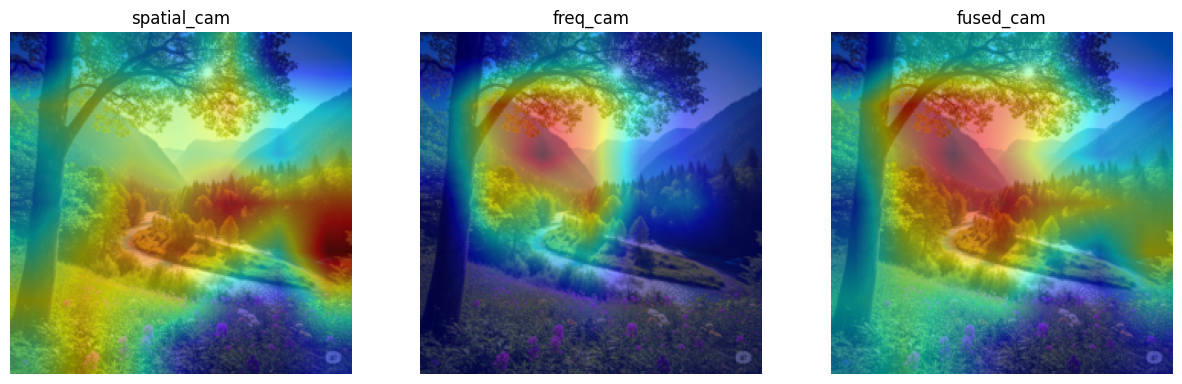


🔬 Extracting key features for: cycle_gan
Features: ['GLCM', 'Wavelet', 'PSD', 'Spectral Entropy', 'Denoise Residual']

=== GLCM ===
GLCM: contrast=439.621, corr=0.924


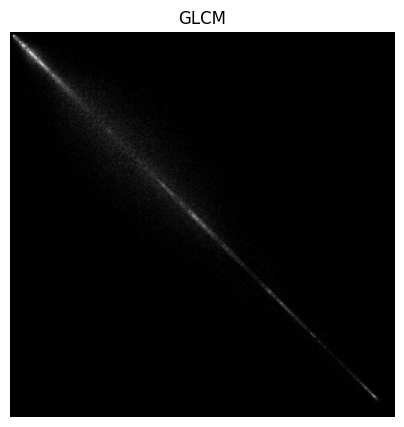


=== Wavelet ===
Wavelet: energy=28.141024


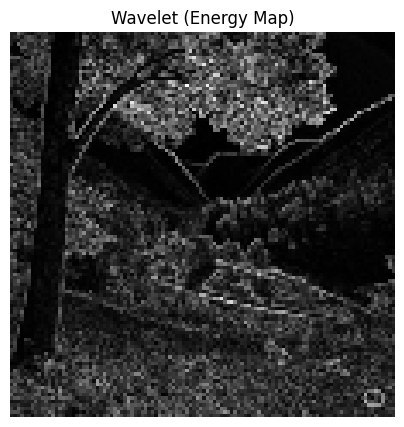


=== PSD ===
PSD: mean=4837.386230


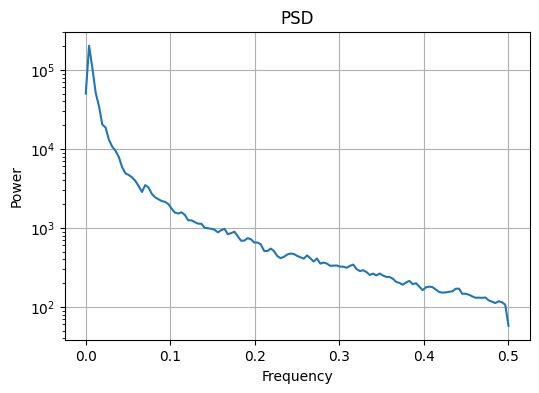


=== Spectral Entropy ===
Spectral Entropy: 11.583008


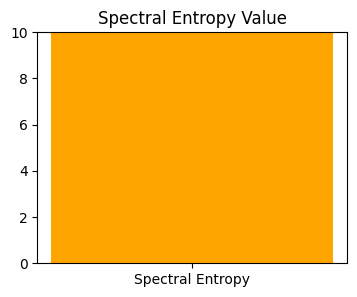


=== Denoise Residual ===
Denoise Residual: mean=105.096999


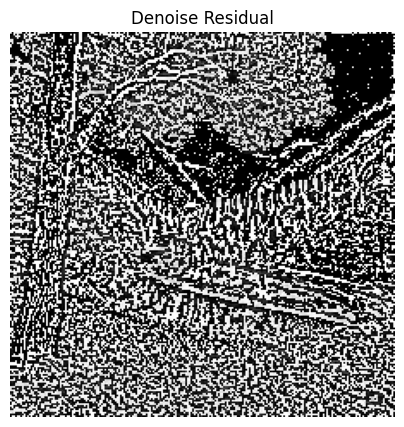

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import numpy as np
import timm
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from scipy.stats import entropy, kurtosis, skew
from scipy import signal
import pywt

# ============================================================
# CONFIG
# ============================================================
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", DEVICE)

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "pro_gan", "projected_gan", "latent_diffusion", "stable_diffusion", "vq_diffusion"
]

# ============================================================
# MAPPING 10 FAKE CLASSES ↔ 10 MAIN FEATURES
# ============================================================
FEATURE_MAP = {
    "stylegan1": ["PRNU", "High-Freq", "PSD", "Wavelet", "Spectral Entropy"],
    "stylegan2": ["High-Freq", "PSD", "Wavelet", "Spectral Centroid", "Gradient"],
    "stylegan3": ["Spectral Entropy", "Autocorrelation", "PSD", "Wavelet", "Gradient"],
    "big_gan": ["PSD", "Spectral Centroid", "High-Freq", "Gradient", "PRNU"],
    "cycle_gan": ["GLCM", "Wavelet", "PSD", "Spectral Entropy", "Denoise Residual"],
    "pro_gan": ["PRNU", "High-Freq", "PSD", "Autocorrelation", "Wavelet"],
    "projected_gan": ["Spectral Centroid", "PSD", "Gradient", "Wavelet", "PRNU"],
    "latent_diffusion": ["Spectral Entropy", "PSD", "Denoise Residual", "Wavelet", "Gradient"],
    "stable_diffusion": ["Denoise Residual", "PSD", "Spectral Centroid", "Gradient", "Wavelet"],
    "vq_diffusion": ["Spectral Centroid", "PSD", "Wavelet", "Spectral Entropy", "GLCM"]
}

ALL_FEATURES = list(set().union(*FEATURE_MAP.values()))

# ============================================================
# MODEL: DualStreamEffNetB3
# ============================================================
class DualStreamEffNetB3(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.spatial_cnn = timm.create_model("efficientnet_b3", pretrained=False, num_classes=0)
        self.freq_cnn = timm.create_model("efficientnet_b3", pretrained=False, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s_feat = self.spatial_cnn(spatial_x)
        f_feat = self.freq_cnn(freq_x)
        fused = torch.cat((s_feat, f_feat), dim=1)
        fused = torch.relu(self.fusion(fused))
        binary_out = self.binary_head(fused)
        multi_out = self.multi_class_head(fused)
        return binary_out, multi_out

# ============================================================
# XGrad-CAM for DualStream
# ============================================================
class XGradCAMDual:
    def __init__(self, model, img_size=224, device=None):
        self.model = model
        self.device = device or next(model.parameters()).device
        self.img_size = img_size
        self.model.eval()

    def _find_target_layer(self, cnn_branch):
        for m in reversed(list(cnn_branch.modules())):
            if isinstance(m, nn.Conv2d):
                return m
        raise ValueError("No Conv2d found in branch")

    def _register_hooks(self, layer):
        activations, gradients = {}, {}
        def fwd_hook(module, inp, out):
            activations["value"] = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            gradients["value"] = grad_out[0].detach()
        fwd = layer.register_forward_hook(fwd_hook)
        bwd = layer.register_backward_hook(bwd_hook)
        return activations, gradients, fwd, bwd

    def _compute_xgradcam(self, acts, grads):
        eps = 1e-8
        numerator = (grads * acts).mean(dim=(2,3), keepdim=True)
        denominator = 2.0 * (acts ** 2).mean(dim=(2,3), keepdim=True) + eps
        weights = numerator / denominator
        cam = torch.relu((weights * acts).sum(dim=1))
        cam0 = cam[0].cpu().numpy()
        cam0 -= cam0.min()
        if cam0.max() > 0:
            cam0 /= cam0.max()
        return cv2.resize(cam0, (self.img_size, self.img_size))

    def generate(self, img_spatial, img_freq, branch="fused", target=("multi", None)):
        img_spatial = img_spatial.to(self.device)
        img_freq = img_freq.to(self.device)

        def compute_for(branch_name):
            cnn_branch = self.model.spatial_cnn if branch_name == "spatial" else self.model.freq_cnn
            target_layer = self._find_target_layer(cnn_branch)
            acts, grads, fwd, bwd = self._register_hooks(target_layer)
            self.model.zero_grad()
            b_out, m_out = self.model(img_spatial, img_freq)
            if target[0] == "multi":
                class_idx = target[1] if target[1] is not None else int(m_out.argmax(dim=1).item())
                score = m_out[:, class_idx]
            else:
                class_idx = target[1] if target[1] is not None else int(b_out.argmax(dim=1).item())
                score = b_out[:, class_idx]
            score.sum().backward(retain_graph=True)
            cam = self._compute_xgradcam(acts["value"], grads["value"])
            fwd.remove(); bwd.remove()
            self.model.zero_grad()
            return cam

        if branch == "spatial":
            return {"spatial_cam": compute_for("spatial")}
        elif branch == "frequency":
            return {"freq_cam": compute_for("frequency")}
        else:
            s = compute_for("spatial")
            f = compute_for("frequency")
            fused = (s + f) / 2.0
            fused -= fused.min()
            if fused.max() > 0:
                fused /= fused.max()
            return {"spatial_cam": s, "freq_cam": f, "fused_cam": fused}

    @staticmethod
    def overlay(image, activation, alpha=0.5):
        img = np.float32(image)
        heat = np.uint8(255 * activation)
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB) / 255.0
        out = (1 - alpha) * img + alpha * heat
        out = out / (out.max() + 1e-8)
        return out

# ============================================================
# IMAGE PREPROCESSING
# ============================================================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def image_to_freq_tensor_prep(pil_img, img_size=IMG_SIZE):
    t = transforms.ToTensor()(pil_img)
    f = torch.fft.fft2(t)
    fshift = torch.fft.fftshift(f)
    mag = torch.log1p(torch.abs(fshift))
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    mag = TF.resize(mag, (img_size, img_size))
    mag = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(mag)
    return mag

# ============================================================
# FEATURE EXTRACTION FUNCTIONS (10 MAIN)
# ============================================================
def feature_PRNU(image_np):
    residual = cv2.GaussianBlur((image_np*255).astype(np.uint8), (5,5), 0).astype(np.float32)/255.0
    prnu = image_np - residual
    return prnu, np.mean(np.abs(prnu))

def feature_highfreq(gray):
    fshift = np.fft.fftshift(np.fft.fft2(gray))
    mag = 20 * np.log(np.abs(fshift) + 1e-8)
    return mag, np.mean(mag)

def feature_spectral_entropy(freq_np):
    p = np.abs(freq_np)**2
    return entropy(p.flatten())

def feature_psd(gray):
    f_psd, Pxx = signal.welch(gray.flatten())
    return f_psd, Pxx, np.mean(Pxx)

def feature_wavelet(gray):
    coeffs2 = pywt.dwt2(gray, 'haar')
    _, (cH, cV, cD) = coeffs2
    e = np.mean(np.abs(cH) + np.abs(cV) + np.abs(cD))
    return (cH, cV, cD), e

def feature_autocorrelation(gray):
    res = cv2.matchTemplate(gray, gray, cv2.TM_CCORR_NORMED)
    return res, np.mean(res)

def feature_glcm(gray):
    img8 = (gray).astype(np.uint8)
    g = graycomatrix(img8, [1], [0, np.pi/4], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(g, 'contrast').mean()
    corr = graycoprops(g, 'correlation').mean()
    return g, contrast, corr

def feature_gradient(gray):
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad = np.sqrt(gx**2 + gy**2)
    return grad, np.mean(grad)

def feature_spectral_centroid(gray):
    f_welch, Pxx = signal.welch(gray.flatten())
    centroid = np.sum(f_welch * Pxx) / (np.sum(Pxx) + 1e-8)
    return centroid

def feature_denoise_residual(gray):
    blur = cv2.medianBlur(gray, 5)
    residual = gray - blur
    return residual, np.mean(np.abs(residual))

# ============================================================
# MODEL LOAD
# ============================================================
checkpoint_path = "/kaggle/input/checkpoint3eff/keras/default/1/checkpoint_epoch_3eff.pth"
model = DualStreamEffNetB3(num_fake_classes=len(FAKE_CLASSES)).to(DEVICE)

if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt)
    print("✅ Checkpoint loaded.")
else:
    print("⚠️ Checkpoint not found, using random init.")

model.eval()

# ============================================================
# TEST IMAGE + CAM + FEATURE EXTRACTION
# ============================================================
img_path = "/kaggle/input/testarrtifact/fake_real_test/Gemini_Generated_Image_2gs3852gs3852gs3.png"
if not os.path.exists(img_path):
    print("⚠️ Image not found at", img_path)
else:
    pil_img = Image.open(img_path).convert("RGB")
    img_spatial = transform(pil_img).unsqueeze(0).to(DEVICE)
    img_freq = image_to_freq_tensor_prep(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        b_out, m_out = model(img_spatial, img_freq)
        b_pred = int(b_out.argmax(dim=1).item())
        m_pred = int(m_out.argmax(dim=1).item())

    binary_label = "real" if b_pred == 0 else "fake"
    multi_label = FAKE_CLASSES[m_pred] if binary_label == "fake" else REAL_CLASSES[0]
    print(f"\n🔎 Prediction → Binary: {binary_label}, Class: {multi_label} (idx={m_pred})")

    # XGrad-CAM visualization
    cammer = XGradCAMDual(model, img_size=IMG_SIZE, device=DEVICE)
    cams = cammer.generate(img_spatial, img_freq, branch="fused", target=("multi", m_pred))

    orig_np = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, key in zip(axes, ["spatial_cam", "freq_cam", "fused_cam"]):
        overlay = cammer.overlay(orig_np, cams[key], alpha=0.5)
        ax.imshow(overlay)
        ax.set_title(key)
        ax.axis("off")
    plt.show()

    # Feature extraction
    # ============================================================
# FEATURE VISUALIZATION
# ============================================================
# ============================================================
# FEATURE VISUALIZATION (FAKE + REAL)
# ============================================================
if binary_label == "fake" and multi_label in FEATURE_MAP:
    # -----------------------------
    # FAKE IMAGE FEATURES
    # -----------------------------
    features = FEATURE_MAP[multi_label]
    print(f"\n🔬 Extracting key features for: {multi_label}\nFeatures: {features}\n")

    gray = cv2.cvtColor((orig_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    for f in features:
        try:
            print(f"=== {f} ===")
            if f == "PRNU":
                prnu, val = feature_PRNU(orig_np)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(prnu, cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "High-Freq":
                mag, val = feature_highfreq(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(mag, cmap="inferno")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "Spectral Entropy":
                se = feature_spectral_entropy(img_freq.cpu().numpy())
                print(f"{f}: {se:.6f}")
                plt.figure(figsize=(4,3))
                plt.bar(["Spectral Entropy"], [se], color='orange')
                plt.title(f"{f} Value")
                plt.ylim(0, 10)
                plt.show()

            elif f == "PSD":
                fw, Pxx, val = feature_psd(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(6,4))
                plt.semilogy(fw, Pxx)
                plt.title(f"{f}")
                plt.xlabel("Frequency")
                plt.ylabel("Power")
                plt.grid(True)
                plt.show()

            elif f == "Wavelet":
                (cH, cV, cD), val = feature_wavelet(gray)
                print(f"{f}: energy={val:.6f}")
                energy_map = np.abs(cH) + np.abs(cV) + np.abs(cD)
                plt.figure(figsize=(5,5))
                plt.imshow(energy_map, cmap="gray")
                plt.title(f"{f} (Energy Map)")
                plt.axis("off")
                plt.show()

            elif f == "Autocorrelation":
                res, val = feature_autocorrelation(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(res, cmap="viridis")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "GLCM":
                g, c, corr = feature_glcm(gray)
                print(f"{f}: contrast={c:.3f}, corr={corr:.3f}")
                plt.figure(figsize=(5,5))
                plt.imshow(g[:, :, 0, 0], cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "Gradient":
                grad, val = feature_gradient(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(grad, cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "Spectral Centroid":
                val = feature_spectral_centroid(gray)
                print(f"{f}: {val:.6f}")
                plt.figure(figsize=(4,3))
                plt.bar(["Spectral Centroid"], [val], color='purple')
                plt.title(f"{f} Value")
                plt.ylim(0, 0.5)
                plt.show()

            elif f == "Denoise Residual":
                res, val = feature_denoise_residual(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(res, cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            print("")  # spacing

        except Exception as e:
            print(f"⚠️ Error in {f}: {e}")
            print("")

# ============================================================
# FEATURE VISUALIZATION FOR REAL IMAGES
# ============================================================
elif binary_label == "real":
    real_features = ALL_FEATURES  # Sử dụng tất cả 10 đặc trưng cho ảnh real
    print(f"\n📸 Extracting natural features for REAL image\nFeatures: {real_features}\n")

    gray = cv2.cvtColor((orig_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    for f in real_features:
        try:
            print(f"=== {f} ===")

            if f == "PRNU":
                prnu, val = feature_PRNU(orig_np)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(prnu, cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "High-Freq":
                mag, val = feature_highfreq(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(mag, cmap="inferno")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "Spectral Entropy":
                se = feature_spectral_entropy(img_freq.cpu().numpy())
                print(f"{f}: {se:.6f}")
                plt.figure(figsize=(4,3))
                plt.bar(["Spectral Entropy"], [se], color='orange')
                plt.title(f"{f} Value")
                plt.ylim(0, 10)
                plt.show()

            elif f == "PSD":
                fw, Pxx, val = feature_psd(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(6,4))
                plt.semilogy(fw, Pxx)
                plt.title(f"{f}")
                plt.xlabel("Frequency")
                plt.ylabel("Power")
                plt.grid(True)
                plt.show()

            elif f == "Wavelet":
                (cH, cV, cD), val = feature_wavelet(gray)
                print(f"{f}: energy={val:.6f}")
                energy_map = np.abs(cH) + np.abs(cV) + np.abs(cD)
                plt.figure(figsize=(5,5))
                plt.imshow(energy_map, cmap="gray")
                plt.title(f"{f} (Energy Map)")
                plt.axis("off")
                plt.show()


            elif f == "Autocorrelation":
                res, val = feature_autocorrelation(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(res, cmap="viridis")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "GLCM":
                g, c, corr = feature_glcm(gray)
                print(f"{f}: contrast={c:.3f}, corr={corr:.3f}")
                plt.figure(figsize=(5,5))
                plt.imshow(g[:, :, 0, 0], cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "Gradient":
                grad, val = feature_gradient(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(grad, cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            elif f == "Spectral Centroid":
                val = feature_spectral_centroid(gray)
                print(f"{f}: {val:.6f}")
                plt.figure(figsize=(4,3))
                plt.bar(["Spectral Centroid"], [val], color='purple')
                plt.title(f"{f} Value")
                plt.ylim(0, 0.5)
                plt.show()

            elif f == "Denoise Residual":
                res, val = feature_denoise_residual(gray)
                print(f"{f}: mean={val:.6f}")
                plt.figure(figsize=(5,5))
                plt.imshow(res, cmap="gray")
                plt.title(f"{f}")
                plt.axis("off")
                plt.show()

            print("")

        except Exception as e:
            print(f"⚠️ Error in {f}: {e}")
            print("")

# So sánh với các nghiên cứu khác

**Link github: https://github.com/polimi-ispl/GAN-image-detection**

**Chuẩn hóa dữ liệu ảnh và tạo label binary & multi-class.**

**Tạo MultiTaskDataset để load dữ liệu cho cả hai task.**

**Sử dụng EfficientNet-B0 pretrained làm backbone, tách fc layer cho hai task.**

**Huấn luyện multi-task fine-tune, vừa phân loại real/fake vừa phân loại loại GAN.**

**Hỗ trợ mixed precision (AMP) để tiết kiệm GPU.**

**Có hàm evaluate_full in classification_report, tính accuracy, ROC-AUC, multi-class report.**

**Lưu checkpoint từng epoch để tiếp tục huấn luyện hoặc inference.**

**Đánh giá trên train, val, test đầy đủ sau mỗi epoch.**

In [ ]:
!wget https://www.dropbox.com/s/n1boisish8m6aoj/weights.zip?dl=1 -O weights.zip
!unzip weights.zip
!pip install efficientnet_pytorch


In [ ]:
# ===============================================================
# 1. IMPORTS
# ===============================================================
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from tqdm import tqdm
import numpy as np

# ===============================================================
# 2. CONFIG
# ===============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
num_epochs = 50
learning_rate = 1e-4
weights_path = "/kaggle/working/weights/method_A.pth"  # đường dẫn pretrained
num_workers = 4
pin_memory = True

# ===============================================================
# 3. LOAD CSV
# ===============================================================
train_csv = "train_label.csv"
val_csv = "val_label.csv"
test_csv = "test_label.csv"

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# BINARY label
for df in [train_df, val_df, test_df]:
    df['label_bin'] = df['label'].map({'real': 0, 'fake': 1})

# MULTI-CLASS label
train_multi = train_df[train_df['label'] == 'fake'].copy()
val_multi = val_df[val_df['label'] == 'fake'].copy()
test_multi = test_df[test_df['label'] == 'fake'].copy()

fake_classes = sorted(train_multi['class_name'].unique())
class2idx = {c: i for i, c in enumerate(fake_classes)}
for df in [train_multi, val_multi, test_multi]:
    df['label_idx'] = df['class_name'].map(class2idx)

num_fake_classes = len(fake_classes)
FAKE_CLASSES = fake_classes
print(f"🔍 Số lớp fake: {num_fake_classes}, classes: {FAKE_CLASSES}")

# ===============================================================
# 4. TRANSFORM + DATASET
# ===============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class MultiTaskDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.class_to_idx = class2idx
        self.classes = FAKE_CLASSES

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['image_path']
        label_str = row['label']
        class_name = row.get('class_name', None)
        binary_label = row['label_bin']  # 0 real, 1 fake
        if label_str == "fake" and class_name in self.class_to_idx:
            multi_label = self.class_to_idx[class_name]
        else:
            multi_label = -100  # ignore real
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(binary_label, dtype=torch.long), torch.tensor(multi_label, dtype=torch.long)

def get_dataloader():
    return (
        DataLoader(MultiTaskDataset(train_df, transform), batch_size=batch_size, shuffle=True,
                   num_workers=num_workers, pin_memory=pin_memory),
        DataLoader(MultiTaskDataset(val_df, transform), batch_size=batch_size, shuffle=False,
                   num_workers=num_workers, pin_memory=pin_memory),
        DataLoader(MultiTaskDataset(test_df, transform), batch_size=batch_size, shuffle=False,
                   num_workers=num_workers, pin_memory=pin_memory)
    )

# ===============================================================
# 5. MÔ HÌNH MULTI-TASK (EFFICIENTNET)
# ===============================================================
class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_fake_classes, weights_path):
        super().__init__()
        self.backbone = EfficientNet.from_name('efficientnet-b0')
        state_dict = torch.load(weights_path, map_location='cpu')
        self.backbone.load_state_dict(state_dict, strict=False)
        num_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.fc_binary = nn.Linear(num_features, 2)
        self.fc_multi = nn.Linear(num_features, num_fake_classes)

    def forward(self, x):
        features = self.backbone(x)
        out_bin = self.fc_binary(features)
        out_multi = self.fc_multi(features)
        return out_bin, out_multi

# ===============================================================
# 6. HÀM ĐÁNH GIÁ
# ===============================================================
def evaluate_full(model, loader, mode="train"):
    model.eval()
    total_loss = 0
    all_binary_labels, all_binary_preds, all_binary_probs = [], [], []
    all_multi_labels, all_multi_preds = [], []
    criterion_bin = nn.CrossEntropyLoss()
    criterion_multi = nn.CrossEntropyLoss(ignore_index=-100)

    with torch.no_grad():
        loop = tqdm(loader, desc=f"[{mode.upper()}] Evaluating", ncols=100, leave=False)
        for imgs, bin_labels, multi_labels in loop:
            imgs, bin_labels, multi_labels = imgs.to(device), bin_labels.to(device), multi_labels.to(device)
            outputs_bin, outputs_multi = model(imgs)

            loss_bin = criterion_bin(outputs_bin, bin_labels)
            loss_multi = criterion_multi(outputs_multi, multi_labels)
            loss = loss_bin + loss_multi
            total_loss += loss.item()

            probs_bin = nn.functional.softmax(outputs_bin, dim=1)
            preds_bin = torch.argmax(probs_bin, dim=1)
            all_binary_labels.extend(bin_labels.cpu().numpy())
            all_binary_preds.extend(preds_bin.cpu().numpy())
            all_binary_probs.extend(probs_bin[:, 1].cpu().numpy())

            fake_mask = bin_labels == 1
            if fake_mask.sum() > 0:
                valid_multi_labels = multi_labels[fake_mask]
                valid_multi_preds = torch.argmax(outputs_multi[fake_mask], dim=1)
                valid_mask = valid_multi_labels != -100
                all_multi_labels.extend(valid_multi_labels[valid_mask].cpu().numpy())
                all_multi_preds.extend(valid_multi_preds[valid_mask].cpu().numpy())

    avg_loss = total_loss / len(loader)
    all_binary_labels = np.array(all_binary_labels)
    all_binary_preds = np.array(all_binary_preds)
    all_binary_probs = np.array(all_binary_probs)

    print(f"\n📊 {mode.upper()} — Binary Classification (real vs fake):")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"], digits=4))
    acc_bin = accuracy_score(all_binary_labels, all_binary_preds)
    try:
        roc_auc = roc_auc_score(all_binary_labels, all_binary_probs)
    except:
        roc_auc = np.nan

    if len(all_multi_labels) > 0:
        print(f"\n🎭 {mode.upper()} — Multi-class Classification (fake subclasses):")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES, digits=4))

    print(f"\n✅ {mode.upper()} Accuracy (Binary): {acc_bin*100:.2f}% | ROC-AUC: {roc_auc:.4f} | Loss: {avg_loss:.4f}")
    return avg_loss, acc_bin

# ===============================================================
# 7. TRAIN LOOP (MULTI-TASK)
# ===============================================================
print("\n===== Fine-tune Multi-Task (Binary + Multi-class) =====")
model = MultiTaskEfficientNet(num_fake_classes, weights_path).to(device)
criterion_bin = nn.CrossEntropyLoss()
criterion_multi = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

train_loader, val_loader, test_loader = get_dataloader()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"[Multi-Task] Epoch {epoch+1}/{num_epochs}", ncols=100)
    for imgs, bin_labels, multi_labels in loop:
        imgs, bin_labels, multi_labels = imgs.to(device), bin_labels.to(device), multi_labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs_bin, outputs_multi = model(imgs)
            loss_bin = criterion_bin(outputs_bin, bin_labels)
            loss_multi = criterion_multi(outputs_multi, multi_labels)
            loss = loss_bin + loss_multi
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * imgs.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"\nTrain Loss: {avg_train_loss:.4f}")

    # === Evaluate on 3 sets ===
    print("\n----- TRAIN RESULTS -----")
    evaluate_full(model, train_loader, mode="train")

    print("\n----- VAL RESULTS -----")
    evaluate_full(model, val_loader, mode="val")

    print("\n----- TEST RESULTS -----")
    evaluate_full(model, test_loader, mode="test")

    # Save checkpoint
    ckpt_path = f"/kaggle/working/checkpoint_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), ckpt_path)
    print(f"💾 Saved checkpoint: {ckpt_path}")

print("\n✅ Fine-tune multi-task và đánh giá hoàn tất.")

**Link github: https://github.com/GeoX-Lab/RSTI/tree/main/SFNet**

**Chuẩn hóa dữ liệu từ CSV, tạo label binary & multi-class.**

**MultiTaskDataset trả về image tensor + binary label + multi-class label.**

**Xây dựng SFNet: dual-branch (spatial + frequency), fusion + dual-head.**

**Huấn luyện multi-task fine-tune (binary + fake subclasses).**

**Sử dụng AMP (torch.cuda.amp) để tiết kiệm VRAM và tăng tốc.**

**Tính metrics đầy đủ: binary acc, multi-class acc, ROC-AUC, classification report.**

**Lưu checkpoint mỗi epoch để tiếp tục huấn luyện hoặc inference.**

**Hỗ trợ DataParallel nếu có nhiều GPU.**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# ===============================================================
# 1. Dataset
# ===============================================================

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]
REAL_CLASSES = ["real"]  # gộp tất cả real thành 1 class
ALL_CLASSES = REAL_CLASSES + FAKE_CLASSES

class CSVImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5],
                                 [0.5, 0.5, 0.5])
        ])
        self.binary_map = {'real': 0, 'fake': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['image_path']
        binary_label = self.binary_map[self.df.iloc[idx]['label']]
        class_name = self.df.iloc[idx]['class_name']

        if class_name in FAKE_CLASSES:
            multi_label = FAKE_CLASSES.index(class_name)
        else:
            multi_label = -1  # ảnh real không có nhãn multi-class

        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, binary_label, multi_label

# ===============================================================
# 2. SFNet Architecture (Dual-head)
# ===============================================================

class SFNet_MultiTask(nn.Module):
    def __init__(self, num_binary=2, num_fake_class=10):
        super().__init__()
        from torchvision.models import resnet50
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()

        # Frequency branch
        self.freq_branch = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.AdaptiveAvgPool2d(1)
        )

        # Fusion + heads
        self.fusion = nn.Sequential(
            nn.Linear(2048 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.binary_head = nn.Linear(512, num_binary)
        self.multi_head = nn.Linear(512, num_fake_class)

    def forward(self, x):
        spatial_feat = self.backbone(x)
        freq_feat = self.freq_branch(x)
        freq_feat = freq_feat.view(freq_feat.size(0), -1)
        fused = torch.cat([spatial_feat, freq_feat], dim=1)
        fused = self.fusion(fused)

        out_bin = self.binary_head(fused)
        out_multi = self.multi_head(fused)
        return out_bin, out_multi

# ===============================================================
# 3. Training & Evaluation
# ===============================================================

def train_or_eval(model, loader, optimizer, criterion_bin, criterion_multi, device, scaler=None, mode="train"):
    is_train = mode == "train"
    model.train() if is_train else model.eval()

    total_loss, correct_bin, correct_multi, total_bin, total_multi = 0, 0, 0, 0, 0
    all_labels_bin, all_preds_bin, all_probs_bin = [], [], []
    all_labels_multi, all_preds_multi = [], []

    for imgs, labels_bin, labels_multi in tqdm(loader, desc=f"{mode.upper()}", leave=False):
        imgs, labels_bin = imgs.to(device), labels_bin.to(device)
        labels_multi = labels_multi.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            out_bin, out_multi = model(imgs)
            loss_bin = criterion_bin(out_bin, labels_bin)

            mask = labels_multi != -1
            if mask.any():
                loss_multi = criterion_multi(out_multi[mask], labels_multi[mask])
            else:
                loss_multi = 0.0

            loss = loss_bin + 0.5 * loss_multi if mask.any() else loss_bin

        if is_train:
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)

        # Binary metrics
        preds_bin = out_bin.argmax(1)
        probs_bin = torch.softmax(out_bin, dim=1)[:, 1].detach().cpu().numpy()
        all_labels_bin.extend(labels_bin.cpu().numpy())
        all_preds_bin.extend(preds_bin.cpu().numpy())
        all_probs_bin.extend(probs_bin)
        correct_bin += (preds_bin == labels_bin).sum().item()
        total_bin += imgs.size(0)

        # Multi-class metrics (only for fake)
        if mask.any():
            preds_multi = out_multi[mask].argmax(1)
            all_labels_multi.extend(labels_multi[mask].cpu().numpy())
            all_preds_multi.extend(preds_multi.cpu().numpy())
            correct_multi += (preds_multi == labels_multi[mask]).sum().item()
            total_multi += mask.sum().item()

    acc_bin = correct_bin / total_bin
    acc_multi = correct_multi / total_multi if total_multi > 0 else 0.0
    auc_bin = roc_auc_score(all_labels_bin, all_probs_bin)

    print(f"\n📊 {mode.upper()} — Binary Classification (real vs fake):")
    print(classification_report(all_labels_bin, all_preds_bin, target_names=["real", "fake"], digits=4))

    if total_multi > 0:
        print(f"\n🎭 {mode.upper()} — Multi-class Classification (fake subclasses):")
        print(classification_report(all_labels_multi, all_preds_multi, target_names=FAKE_CLASSES, digits=4))

    return total_loss / total_bin, acc_bin, acc_multi, auc_bin

# ===============================================================
# 4. Main Loop with Checkpoint + Evaluation
# ===============================================================

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Using device: {device} | GPUs: {torch.cuda.device_count()}")

    # Datasets & Loaders
    train_dataset = CSVImageDataset("train_label.csv")
    val_dataset = CSVImageDataset("val_label.csv")
    test_dataset = CSVImageDataset("test_label.csv")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

    # Model
    model = SFNet_MultiTask(num_binary=2, num_fake_class=len(FAKE_CLASSES))
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        print(f"✅ Using DataParallel with {torch.cuda.device_count()} GPUs")
    model = model.to(device)

    # Loss & Optimizer
    criterion_bin = nn.CrossEntropyLoss()
    criterion_multi = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scaler = torch.cuda.amp.GradScaler()  # AMP

    EPOCHS = 50

    for epoch in range(EPOCHS):
        print(f"\n===== Epoch {epoch + 1}/{EPOCHS} =====")
        # --- Train ---
        train_loss, train_bin_acc, train_multi_acc, _ = train_or_eval(
            model, train_loader, optimizer, criterion_bin, criterion_multi, device, scaler=scaler, mode="train"
        )
        print(f"\n✅ TRAIN Accuracy (Binary): {train_bin_acc*100:.2f}% | Multi: {train_multi_acc*100:.2f}% | Loss: {train_loss:.4f}")

        # --- Evaluate ---
        for split_name, loader in [("TRAIN", train_loader), ("VAL", val_loader), ("TEST", test_loader)]:
            print(f"\n----- Evaluating {split_name} -----")
            loss, bin_acc, multi_acc, auc = train_or_eval(
                model, loader, optimizer, criterion_bin, criterion_multi, device, scaler=None, mode=split_name.lower()
            )
            print(f"➡️ {split_name} Binary Acc: {bin_acc*100:.2f}% | Multi Acc: {multi_acc*100:.2f}% | Loss: {loss:.4f} | AUC: {auc:.4f}")

        # --- Save checkpoint ---
        ckpt_path = f"sfnet_multitask_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"💾 Saved checkpoint: {ckpt_path}")

if __name__ == "__main__":
    main()


**Link github: https://github.com/Sergo2020/DIF_pytorch_official**

**Chuẩn hóa dữ liệu từ CSV, tạo label binary & multi-class.**

**MultiTaskDataset trả về image tensor + binary label + multi-class label.**

**Xây dựng DIF Multi-Task: Unet backbone + dual-head (binary + fake subclasses).**

**Huấn luyện multi-task fine-tune (binary + fake subclasses).**

**Tính metrics đầy đủ: binary acc, multi-class acc, classification report.**

**Lưu checkpoint mỗi epoch để tiếp tục huấn luyện hoặc inference.**

**Hỗ trợ ignore_index=-100 cho ảnh real trong multi-class loss.**

In [ ]:
!git clone https://github.com/Sergo2020/DIF_pytorch_official.git
%cd DIF_pytorch_official


In [ ]:
# ===============================================================
# 1. KHAI BÁO THƯ VIỆN
# ===============================================================
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# ===============================================================
# 2. IMPORT UNET TỪ REPO DIF
# ===============================================================
sys.path.append("/kaggle/working/DIF_pytorch_official")  # thay đường dẫn nếu khác
from model import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================================================
# 3. MÔ HÌNH 2 ĐẦU RA (BINARY + MULTI)
# ===============================================================
class DIFMultiTask(nn.Module):
    def __init__(self, num_fake_classes):
        super().__init__()
        self.backbone = Unet(device=device, inp_ch=3, out_ch=128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.fc_binary = nn.Linear(128, 2)
        self.fc_multi = nn.Linear(128, num_fake_classes)

    def forward(self, x):
        x = self.backbone(x)
        if isinstance(x, tuple):
            x = x[0]
        x = self.pool(x)
        x = self.flatten(x)
        out_bin = self.fc_binary(x)
        out_multi = self.fc_multi(x)
        return out_bin, out_multi


# ===============================================================
# 4. DATASET GỘP
# ===============================================================
class MultiTaskDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        fake_classes = sorted(self.data[self.data['label'] == 'fake']['class_name'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(fake_classes)}
        self.classes = fake_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['image_path']
        label_str = row['label']
        class_name = row['class_name']

        binary_label = 0 if label_str == "real" else 1
        if label_str == "fake":
            multi_label = self.class_to_idx[class_name]
        else:
            multi_label = -100  # ignore real trong loss

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(binary_label), torch.tensor(multi_label)


# ===============================================================
# 5. DATA & TRANSFORM
# ===============================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_csv = "/kaggle/working/train_label.csv"
val_csv = "/kaggle/working/val_label.csv"
test_csv = "/kaggle/working/test_label.csv"

train_dataset = MultiTaskDataset(train_csv, transform=transform)
val_dataset = MultiTaskDataset(val_csv, transform=transform)
test_dataset = MultiTaskDataset(test_csv, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

num_fake_classes = len(train_dataset.class_to_idx)
FAKE_CLASSES = train_dataset.classes


# ===============================================================
# 6. TRAIN / VALID FUNCTION
# ===============================================================
def train_or_eval(model, loader, criterion_bin, criterion_multi, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0
    all_binary_preds, all_binary_labels = [], []
    all_multi_preds, all_multi_labels = [], []

    for images, bin_labels, multi_labels in tqdm(loader, desc="Train" if is_train else "Eval", leave=False):
        images = images.to(device)
        bin_labels = bin_labels.to(device)
        multi_labels = multi_labels.to(device)

        if is_train:
            optimizer.zero_grad()

        out_bin, out_multi = model(images)
        loss_bin = criterion_bin(out_bin, bin_labels)
        loss_multi = criterion_multi(out_multi, multi_labels)
        loss = loss_bin + loss_multi

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

        # Binary prediction
        preds_bin = out_bin.argmax(1).detach().cpu().numpy()
        all_binary_preds.extend(preds_bin)
        all_binary_labels.extend(bin_labels.cpu().numpy())

        # Multi-class prediction (chỉ fake)
        fake_mask = bin_labels == 1
        valid_multi_labels = multi_labels[fake_mask]
        valid_multi_preds = out_multi.argmax(1)[fake_mask]
        valid_mask = valid_multi_labels != -100

        all_multi_labels.extend(valid_multi_labels[valid_mask].cpu().numpy())
        all_multi_preds.extend(valid_multi_preds[valid_mask].cpu().numpy())

    avg_loss = total_loss / len(loader)

    # ==== Report ====
    print(f"\n📊 Binary Classification (real vs fake):")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=["real", "fake"], digits=4))

    if len(all_multi_labels) > 0:
        print(f"\n🎭 Multi-class Classification (fake subclasses):")
        print(classification_report(all_multi_labels, all_multi_preds, target_names=FAKE_CLASSES, digits=4))

    acc_bin = accuracy_score(all_binary_labels, all_binary_preds)
    print(f"\n✅ Accuracy (Binary): {acc_bin*100:.2f}% | Loss: {avg_loss:.4f}")
    return avg_loss, acc_bin


# ===============================================================
# 7. TRAINING + EVALUATION SAU MỖI EPOCH
# ===============================================================
model = DIFMultiTask(num_fake_classes=num_fake_classes).to(device)
criterion_bin = nn.CrossEntropyLoss()
criterion_multi = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 50
for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

    # Train
    train_loss, train_acc = train_or_eval(model, train_loader, criterion_bin, criterion_multi, optimizer)
    # Validation
    val_loss, val_acc = train_or_eval(model, val_loader, criterion_bin, criterion_multi)

    # Save checkpoint
    ckpt_path = f"/kaggle/working/checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_acc": val_acc,
    }, ckpt_path)
    print(f"💾 Saved checkpoint: {ckpt_path}")

# ===============================================================
# 8. EVALUATE TRÊN TEST SET
# ===============================================================
print("\n🧪 Evaluating on TEST set...")
test_loss, test_acc = train_or_eval(model, test_loader, criterion_bin, criterion_multi)
print(f"🎯 Final Test Accuracy: {test_acc*100:.2f}%")


**Link github: https://github.com/RUB-SysSec/GANDCTAnalysis**

**Chuẩn hóa dữ liệu từ CSV, tạo binary label + multi-class label.**

**Triển khai DCT feature extraction cho ảnh RGB, đầu vào model.**

**Xây dựng ResNet18 multi-head: binary + fake subclasses.**

**Huấn luyện multi-task trên train_loader, cập nhật optimizer Adam.**

**Tính metrics binary & multi-class, in classification report + ROC-AUC.**

**Lưu checkpoint mỗi epoch để tiếp tục huấn luyện hoặc inference.**

In [ ]:

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
from tqdm import tqdm
import cv2
import os

# =========================================================
# 1️⃣ Dataset CSV & Classes
# =========================================================
REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

train_csv = "/kaggle/working/train_label.csv"
val_csv   = "/kaggle/working/val_label.csv"
test_csv  = "/kaggle/working/test_label.csv"

# =========================================================
# 2️⃣ DCT Feature Extraction
# =========================================================
def extract_dct_features(img_pil):
    """
    Chuyển ảnh PIL sang DCT 8x8 block (RGB) -> tensor (3, H, W)
    Resize ảnh 224x224
    """
    img = np.array(img_pil.resize((224,224))).astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0
    dct_channels = []
    for c in range(3):
        channel = img[:,:,c]
        channel = cv2.dct(channel)
        dct_channels.append(channel)
    dct_tensor = torch.tensor(np.stack(dct_channels, axis=0), dtype=torch.float)
    return dct_tensor

# =========================================================
# 3️⃣ Dataset
# =========================================================
class GANImageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.fake_to_idx = {cls: i for i, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_pil = Image.open(row['image_path']).convert("RGB")
        dct_tensor = extract_dct_features(img_pil)
        label_bin = 0 if row['label']=='real' else 1
        label_multi = self.fake_to_idx.get(row['class_name'], -1)
        return dct_tensor, torch.tensor(label_bin, dtype=torch.long), torch.tensor(label_multi, dtype=torch.long)

train_ds = GANImageDataset(train_csv)
val_ds   = GANImageDataset(val_csv)
test_ds  = GANImageDataset(test_csv)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

# =========================================================
# 4️⃣ Model ResNet18-DCT Multi-head
# =========================================================
class GANClassifierDCT(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.binary_head = nn.Linear(in_features, 2)
        self.multi_head  = nn.Linear(in_features, len(FAKE_CLASSES))

    def forward(self, x):
        feat = self.backbone(x)
        return self.binary_head(feat), self.multi_head(feat)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GANClassifierDCT().to(device)

criterion_bin = nn.CrossEntropyLoss()
criterion_multi = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# =========================================================
# 5️⃣ Evaluate function
# =========================================================
def evaluate(model, loader, split_name):
    model.eval()
    y_true_bin, y_pred_bin = [], []
    y_true_multi, y_pred_multi = [], []

    with torch.no_grad():
        for imgs, lbl_bin, lbl_multi in loader:
            imgs, lbl_bin, lbl_multi = imgs.to(device), lbl_bin.to(device), lbl_multi.to(device)
            out_bin, out_multi = model(imgs)
            pred_bin = torch.argmax(out_bin, dim=1)
            pred_multi = torch.argmax(out_multi, dim=1)

            y_true_bin.extend(lbl_bin.cpu().numpy())
            y_pred_bin.extend(pred_bin.cpu().numpy())

            mask = lbl_bin==1
            y_true_multi.extend(lbl_multi[mask].cpu().numpy())
            y_pred_multi.extend(pred_multi[mask].cpu().numpy())

    # Binary
    print(f"\n📊 {split_name} — Binary Classification:")
    print(classification_report(y_true_bin, y_pred_bin, target_names=["real","fake"], digits=4))
    try:
        auc = roc_auc_score(y_true_bin, y_pred_bin)
    except:
        auc = 0
    acc_bin = np.mean(np.array(y_true_bin)==np.array(y_pred_bin))
    print(f"✅ {split_name} Accuracy (Binary): {acc_bin*100:.2f}% | ROC-AUC: {auc:.4f}")

    # Multi-class
    print(f"\n🎭 {split_name} — Multi-class Classification (fake subclasses):")
    print(classification_report(y_true_multi, y_pred_multi, target_names=FAKE_CLASSES, digits=4))
    acc_multi = np.mean(np.array(y_true_multi)==np.array(y_pred_multi))
    print(f"✅ {split_name} Accuracy (Multi): {acc_multi*100:.2f}%")

# =========================================================
# 6️⃣ Training Loop + Evaluate + Save per epoch
# =========================================================
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for imgs, lbl_bin, lbl_multi in loop:
        imgs, lbl_bin, lbl_multi = imgs.to(device), lbl_bin.to(device), lbl_multi.to(device)
        optimizer.zero_grad()
        out_bin, out_multi = model(imgs)
        loss_bin = criterion_bin(out_bin, lbl_bin)
        mask = (lbl_bin==1)
        if mask.sum()>0:
            loss_multi = criterion_multi(out_multi[mask], lbl_multi[mask])
        else:
            loss_multi = 0
        loss = loss_bin + loss_multi
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\n🧠 Epoch {epoch+1}/{EPOCHS} — Loss: {avg_loss:.4f}")

    # In kết quả sau mỗi epoch
    print("\nTRAIN RESULTS:")
    evaluate(model, train_loader, "TRAIN")

    print("\nVAL RESULTS:")
    evaluate(model, val_loader, "VAL")

    print("\nTEST RESULTS:")
    evaluate(model, test_loader, "TEST")

    # Lưu model checkpoint
    save_path = f"gan_dct_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"\n💾 Saved model checkpoint: {save_path}")


**Sử dụng tập test (1000 ảnh bao gồm Real và Fake)**

**Nén ảnh JPEG ở các mức quality(90, 80,...) và trực quan bằng Grad-cam**


In [ ]:
import os
import cv2
import torch
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ========================
# CONFIG
# ========================
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", DEVICE)

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "pro_gan", "projected_gan", "latent_diffusion", "stable_diffusion", "vq_diffusion"
]

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ========================
# HELPER FUNCTIONS
# ========================
import io

def compress_jpeg(img, quality=75):
    pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    buf = io.BytesIO()
    pil.save(buf, format='JPEG', quality=int(quality))
    buf.seek(0)
    pil2 = Image.open(buf).convert('RGB')
    return cv2.cvtColor(np.array(pil2), cv2.COLOR_RGB2BGR)

def image_to_freq_tensor_prep(pil_img, img_size=IMG_SIZE):
    arr = np.array(pil_img).astype(np.float32)/255.0
    arr = arr[..., :3]
    t = torch.from_numpy(arr.transpose(2,0,1)).float()    # C,H,W
    f = torch.fft.fft2(t)
    fshift = torch.fft.fftshift(f)
    mag = torch.log1p(torch.abs(fshift))
    mag = mag - mag.min()
    if mag.max() > 0:
        mag = mag / (mag.max()+1e-8)
    mag = mag.unsqueeze(0)
    mag = F.interpolate(mag, size=(img_size,img_size), mode='bilinear', align_corners=False)
    mag = mag.squeeze(0)
    mean = torch.tensor([0.485,0.456,0.406]).view(-1,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(-1,1,1)
    mag = (mag - mean)/std
    return mag

# ========================
# MODEL DEFINITION
# ========================
class DualStreamEffNetB3(torch.nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10, pretrained=False):
        super().__init__()
        self.spatial_cnn = timm.create_model("efficientnet_b3", pretrained=pretrained, num_classes=0)
        self.freq_cnn = timm.create_model("efficientnet_b3", pretrained=pretrained, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = torch.nn.Linear(self.feature_dim*2, self.feature_dim)
        self.binary_head = torch.nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = torch.nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s_feat = self.spatial_cnn(spatial_x)
        f_feat = self.freq_cnn(freq_x)
        fused = torch.cat((s_feat,f_feat), dim=1)
        fused = F.relu(self.fusion(fused))
        binary_out = self.binary_head(fused)
        multi_out = self.multi_class_head(fused)
        return binary_out, multi_out

# ========================
# LOAD CHECKPOINT
# ========================
checkpoint_path = "/kaggle/input/checkpoint3ffffffff/keras/default/1/checkpoint_epoch_3eff.pth"
model = DualStreamEffNetB3(num_fake_classes=len(FAKE_CLASSES)).to(DEVICE)
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=DEVICE)
    try:
        model.load_state_dict(ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt)
        print("✅ Checkpoint loaded.")
    except Exception as e:
        print("⚠️ Load checkpoint failed:", e)
else:
    print("⚠️ Checkpoint not found, using random init.")
model.eval()

# ========================
# BATCHED EVALUATION
# ========================
from math import ceil

def evaluate_paths(paths, labels, batch_size=32, mode="combined", distort_func=None):
    total, correct = 0, 0
    n = len(paths)
    for i in range(0,n,batch_size):
        batch_paths = paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        s_list, f_list = [], []
        for p in batch_paths:
            img = cv2.imread(p)
            if img is None:
                img = np.ones((IMG_SIZE,IMG_SIZE,3),dtype=np.uint8)*127
            if distort_func is not None:
                img = distort_func(img)
            pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            s_list.append(transform(pil).unsqueeze(0))
            f_list.append(image_to_freq_tensor_prep(pil).unsqueeze(0))
        s_batch = torch.cat(s_list, dim=0).to(DEVICE)
        f_batch = torch.cat(f_list, dim=0).to(DEVICE)

        with torch.no_grad():
            b_out,_ = model(s_batch,f_batch)
            preds_fused = b_out.argmax(dim=1).cpu().numpy()

            # spatial only
            s_feat = model.spatial_cnn(s_batch)
            fused_s = F.relu(model.fusion(torch.cat((s_feat, torch.zeros_like(s_feat).to(DEVICE)), dim=1)))
            preds_s = model.binary_head(fused_s).argmax(dim=1).cpu().numpy()

            # freq only
            f_feat = model.freq_cnn(f_batch)
            fused_f = F.relu(model.fusion(torch.cat((torch.zeros_like(f_feat).to(DEVICE), f_feat), dim=1)))
            preds_f = model.binary_head(fused_f).argmax(dim=1).cpu().numpy()

        if mode=="combined": preds = preds_fused
        elif mode=="spatial": preds = preds_s
        elif mode=="freq": preds = preds_f
        else: raise ValueError("mode must be combined|spatial|freq")

        total += len(batch_labels)
        correct += (preds == np.array(batch_labels)).sum()
    return correct/total if total>0 else 0.0

def eval_all_modes(paths, labels, batch_size=32, distort_func=None):
    acc_comb = evaluate_paths(paths, labels, batch_size=batch_size, mode="combined", distort_func=distort_func)
    acc_spat = evaluate_paths(paths, labels, batch_size=batch_size, mode="spatial", distort_func=distort_func)
    acc_freq = evaluate_paths(paths, labels, batch_size=batch_size, mode="freq", distort_func=distort_func)
    return acc_comb, acc_spat, acc_freq

# ========================
# TEST IMAGES
# ========================
test_folder = "/kaggle/input/1000anhhhh/1000anh"
test_imgs = [os.path.join(test_folder,f) for f in os.listdir(test_folder) if f.lower().endswith((".png",".jpg",".jpeg"))][:1000]
test_labels = [0 if any(rc in os.path.basename(f).lower() for rc in REAL_CLASSES) else 1 for f in test_imgs]
print("Test images:", len(test_imgs))

# ========================
# RUN JPEG EXPERIMENT
# ========================
jpeg_vals = [10,20,30,40,50,60,70,80,90,100]
jpeg_results = {"quality": [], "combined": [], "spatial": [], "freq": []}

for q in jpeg_vals:
    print("Testing JPEG quality =", q)
    acc_c, acc_s, acc_f = eval_all_modes(
        test_imgs, test_labels, batch_size=32,
        distort_func=lambda img: compress_jpeg(img, quality=q)
    )
    jpeg_results["quality"].append(q)
    jpeg_results["combined"].append(acc_c)
    jpeg_results["spatial"].append(acc_s)
    jpeg_results["freq"].append(acc_f)
    print(f"Q={q}: combined={acc_c:.4f}, spatial={acc_s:.4f}, freq={acc_f:.4f}")

# ========================
# PLOT
# ========================
plt.figure(figsize=(8,5))
plt.plot(jpeg_results["quality"], jpeg_results["combined"], '-s', label='combined')
plt.plot(jpeg_results["quality"], jpeg_results["spatial"], '-o', label='spatial')
plt.plot(jpeg_results["quality"], jpeg_results["freq"], '-x', label='freq')
plt.gca().invert_xaxis()
plt.xlabel("JPEG quality")
plt.ylabel("Accuracy")
plt.title("JPEG robustness")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class XGradCAMDual:
    def __init__(self, model, img_size=224, device=None):
        self.model = model
        self.device = device or next(model.parameters()).device
        self.img_size = img_size
        self.model.eval()

    def _find_target_layer(self, cnn_branch):
        for m in reversed(list(cnn_branch.modules())):
            if isinstance(m, torch.nn.Conv2d):
                return m
        raise ValueError("No Conv2d found in branch")

    def _register_hooks(self, layer):
        acts, grads = {}, {}
        def fwd_hook(module, inp, out):
            acts["value"] = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            grads["value"] = grad_out[0].detach()
        fwd = layer.register_forward_hook(fwd_hook)
        bwd = layer.register_backward_hook(bwd_hook)
        return acts, grads, fwd, bwd

    def _compute_xgradcam(self, acts, grads):
        eps = 1e-8
        weights = ((grads * acts).mean(dim=(2,3), keepdim=True)) / (2*(acts**2).mean(dim=(2,3), keepdim=True)+eps)
        cam = torch.relu((weights*acts).sum(dim=1))
        cam0 = cam[0].cpu().numpy()
        cam0 -= cam0.min()
        if cam0.max()>0:
            cam0 /= cam0.max()
        return cv2.resize(cam0, (self.img_size,self.img_size))

    def generate(self, img_spatial, img_freq, branch="fused", target_class=None):
        img_spatial = img_spatial.to(self.device)
        img_freq = img_freq.to(self.device)

        def compute_for(branch_name):
            cnn_branch = self.model.spatial_cnn if branch_name=="spatial" else self.model.freq_cnn
            layer = self._find_target_layer(cnn_branch)
            acts, grads, fwd, bwd = self._register_hooks(layer)
            self.model.zero_grad()
            b_out, m_out = self.model(img_spatial, img_freq)
            if target_class is None:
                target_idx = int(b_out.argmax(dim=1).item())
            else:
                target_idx = target_class
            score = b_out[:, target_idx]  # for simplicity use binary output
            score.sum().backward(retain_graph=True)
            cam = self._compute_xgradcam(acts["value"], grads["value"])
            fwd.remove(); bwd.remove()
            self.model.zero_grad()
            return cam

        if branch=="spatial": return {"spatial_cam": compute_for("spatial")}
        elif branch=="frequency": return {"freq_cam": compute_for("frequency")}
        else:
            s = compute_for("spatial")
            f = compute_for("frequency")
            fused = (s+f)/2
            fused -= fused.min()
            if fused.max()>0: fused/=fused.max()
            return {"spatial_cam": s, "freq_cam": f, "fused_cam": fused}

    @staticmethod
    def overlay(image, activation, alpha=0.5):
        img = np.float32(image)
        heat = np.uint8(255*activation)
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)/255.0
        out = (1-alpha)*img + alpha*heat
        return out
# Chọn 1 tấm ảnh trực quan
# ========================
# Vòng lặp Grad-CAM cho các mức JPEG
# ========================
jpeg_levels = list(range(10, 101, 10))  # 10,20,...100
cammer = XGradCAMDual(model, img_size=IMG_SIZE, device=DEVICE)

# Chọn 1 tấm ảnh trực quan
img_vis_path = test_imgs[0]
img_orig = cv2.imread(img_vis_path)
orig_np = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)/255.0

for q in jpeg_levels:
    # Nén JPEG với chất lượng q
    img_vis_cv = compress_jpeg(img_orig, quality=q)
    pil_img_dist = Image.fromarray(cv2.cvtColor(img_vis_cv, cv2.COLOR_BGR2RGB))
    
    # Tạo tensor cho mô hình
    img_s_dist = transform(pil_img_dist).unsqueeze(0).to(DEVICE)
    img_f_dist = image_to_freq_tensor_prep(pil_img_dist).unsqueeze(0).to(DEVICE)
    
    # Grad-CAM
    cams = cammer.generate(img_s_dist, img_f_dist, branch="fused")
    
    # Resize ảnh gốc để overlay
    orig_resized = cv2.resize(cv2.cvtColor(img_vis_cv, cv2.COLOR_BGR2RGB)/255.0, (IMG_SIZE, IMG_SIZE))
    
    # Vẽ overlay
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ax,key in zip(axes, ["spatial_cam","freq_cam","fused_cam"]):
        overlay = cammer.overlay(orig_resized, cams[key])
        ax.imshow(overlay)
        ax.set_title(f"{key} - JPEG Quality {q}")
        ax.axis("off")
    plt.suptitle(f"Grad-CAM Overlays for JPEG Quality {q}", fontsize=16)
    plt.show()



**Làm mờ (Gaussian Blur)**

In [ ]:
# ========================
# GAUSSIAN BLUR EXPERIMENT
# ========================

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# ---------- 1. Hàm làm mờ ----------
def distort_gaussian_blur(img, kernel_size=3, sigma=0.5):
    """
    img: ảnh BGR numpy [H,W,3] uint8
    kernel_size: 3,5,7
    sigma: độ lệch chuẩn Gaussian
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

# ---------- 2. Các mức blur thử nghiệm ----------
blur_levels = [
    {"kernel":3, "sigma":0.5},
    {"kernel":5, "sigma":1.0},
    {"kernel":7, "sigma":2.0}
]

# ---------- 3. Thực hiện đánh giá ----------
blur_results = {"kernel": [], "sigma": [], "combined": [], "spatial": [], "freq": []}

for bl in blur_levels:
    print(f"Testing Gaussian Blur: kernel={bl['kernel']}, sigma={bl['sigma']}")
    acc_c, acc_s, acc_f = eval_all_modes(
        test_imgs, test_labels, batch_size=32,
        distort_func=lambda img, k=bl['kernel'], s=bl['sigma']: distort_gaussian_blur(img, k, s)
    )
    blur_results["kernel"].append(bl["kernel"])
    blur_results["sigma"].append(bl["sigma"])
    blur_results["combined"].append(acc_c)
    blur_results["spatial"].append(acc_s)
    blur_results["freq"].append(acc_f)
    print(f"kernel={bl['kernel']}, sigma={bl['sigma']}: combined={acc_c:.4f}, spatial={acc_s:.4f}, freq={acc_f:.4f}")

# ---------- 4. Vẽ biểu đồ accuracy ----------
plt.figure(figsize=(8,5))
plt.plot(blur_results["sigma"], blur_results["combined"], '-s', label='combined')
plt.plot(blur_results["sigma"], blur_results["spatial"], '-o', label='spatial')
plt.plot(blur_results["sigma"], blur_results["freq"], '-x', label='freq')
plt.xlabel("Gaussian Sigma")
plt.ylabel("Accuracy")
plt.title("Gaussian Blur Robustness")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 5. Chọn 1 ảnh trực quan để vẽ XGrad-CAM ----------
# Chọn ảnh đầu tiên trong tập test
img_path = test_imgs[0]
pil_img = Image.open(img_path).convert("RGB")
img_np = np.array(pil_img)

# Áp dụng Gaussian Blur mức trung bình (kernel=5, sigma=1.0)
img_blur = distort_gaussian_blur(img_np, kernel_size=5, sigma=1.0)
pil_blur = Image.fromarray(img_blur)

# Chuyển sang tensor
img_spatial = transform(pil_blur).unsqueeze(0).to(DEVICE)
img_freq = image_to_freq_tensor_prep(pil_blur).unsqueeze(0).to(DEVICE)

# ---------- 6. Tạo CAM ----------
# Giả sử bạn có class XGradCAMDual(model, img_size, device)
cammer = XGradCAMDual(model, img_size=IMG_SIZE, device=DEVICE)
cams = cammer.generate(img_spatial, img_freq, branch="fused")

orig_np = np.array(pil_blur.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32)/255.0

# ---------- 7. Vẽ overlay CAM ----------
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ax, key in zip(axes, ["spatial_cam","freq_cam","fused_cam"]):
    overlay = cammer.overlay(orig_np, cams[key], alpha=0.5)
    ax.imshow(overlay)
    ax.set_title(key)
    ax.axis("off")
plt.show()


**Thay đổi kích thước**

In [ ]:
# ========================
# RESIZE + UPSCALE WITH Grad-CAM
# ========================
cammer = XGradCAMDual(model, img_size=IMG_SIZE, device=DEVICE)

resize_ratios = [0.75, 0.5, 0.25]
results_resize = {"ratio": [], "combined": [], "spatial": [], "freq": []}

for r in resize_ratios:
    print(f"\nTesting Resize Upscale: ratio={r}")
    total, correct_c, correct_s, correct_f = 0, 0, 0, 0
    first_img = None

    for i in range(0, len(test_imgs), 32):
        batch_paths = test_imgs[i:i+32]
        batch_labels = test_labels[i:i+32]
        s_list, f_list = [], []

        for p in batch_paths:
            img = cv2.imread(p)
            if img is None:
                img = np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) * 127
            img = resize_upscale(img, r)
            pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            s_list.append(transform(pil).unsqueeze(0))
            f_list.append(image_to_freq_tensor_prep(pil).unsqueeze(0))
            if first_img is None:
                first_img = pil  # ảnh minh họa Grad-CAM

        s_batch = torch.cat(s_list, dim=0).to(DEVICE)
        f_batch = torch.cat(f_list, dim=0).to(DEVICE)

        with torch.no_grad():
            b_out, _ = model(s_batch, f_batch)
            preds_fused = b_out.argmax(dim=1).cpu().numpy()

            # spatial only
            s_feat = model.spatial_cnn(s_batch)
            fused_s = F.relu(model.fusion(torch.cat((s_feat, torch.zeros_like(s_feat).to(DEVICE)), dim=1)))
            preds_s = model.binary_head(fused_s).argmax(dim=1).cpu().numpy()

            # freq only
            f_feat = model.freq_cnn(f_batch)
            fused_f = F.relu(model.fusion(torch.cat((torch.zeros_like(f_feat).to(DEVICE), f_feat), dim=1)))
            preds_f = model.binary_head(fused_f).argmax(dim=1).cpu().numpy()

        total += len(batch_labels)
        correct_c += (preds_fused == np.array(batch_labels)).sum()
        correct_s += (preds_s == np.array(batch_labels)).sum()
        correct_f += (preds_f == np.array(batch_labels)).sum()

    acc_c = correct_c / total
    acc_s = correct_s / total
    acc_f = correct_f / total

    results_resize["ratio"].append(r)
    results_resize["combined"].append(acc_c)
    results_resize["spatial"].append(acc_s)
    results_resize["freq"].append(acc_f)

    print(f"ratio={r}: combined={acc_c:.4f}, spatial={acc_s:.4f}, freq={acc_f:.4f}")

    # ----- Grad-CAM cho first_img -----
    img_s_cam = transform(first_img).unsqueeze(0).to(DEVICE)
    img_f_cam = image_to_freq_tensor_prep(first_img).unsqueeze(0).to(DEVICE)
    cams = cammer.generate(img_s_cam, img_f_cam, branch="fused")
    orig_resized = cv2.resize(np.array(first_img).astype(np.float32)/255.0, (IMG_SIZE, IMG_SIZE))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, key in zip(axes, ["spatial_cam", "freq_cam", "fused_cam"]):
        overlay = cammer.overlay(orig_resized, cams[key], alpha=0.5)
        ax.imshow(overlay)
        ax.set_title(f"{key} | ratio={r}")
        ax.axis("off")
    plt.show()

# ----- Plot Accuracy -----
plt.figure(figsize=(8,5))
plt.plot(results_resize["ratio"], results_resize["combined"], '-s', label='combined')
plt.plot(results_resize["ratio"], results_resize["spatial"], '-o', label='spatial')
plt.plot(results_resize["ratio"], results_resize["freq"], '-x', label='freq')
plt.xlabel("Resize Ratio (Downscale → Upscale)")
plt.ylabel("Accuracy")
plt.title("Resize + Upscale Robustness")
plt.gca().invert_xaxis()  # tỷ lệ giảm từ trái sang phải
plt.legend()
plt.grid(True)
plt.show()


**Trung bình phổ FFT của toàn bộ dữ liệu ( ảnh thật và giả)**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm  # Thư viện hiện thanh tiến trình

def compute_average_spectrum(folder_path, img_size=(512, 512), max_images=1000):
    """
    Tính phổ tần số trung bình của các ảnh trong thư mục.
   
    Args:
        folder_path: Đường dẫn đến thư mục chứa ảnh.
        img_size: Kích thước chuẩn hóa (bắt buộc phải bằng nhau để cộng gộp).
        max_images: Số lượng ảnh tối đa muốn lấy (để test cho nhanh, đặt None nếu muốn chạy hết).
   
    Returns:
        avg_spec: Ma trận phổ trung bình (2D numpy array).
    """
    # Lấy danh sách file ảnh (jpg, png, jpeg)
    types = ('*.jpg', '*.jpeg', '*.png', '*.webp')
    image_files = []
    for files in types:
        image_files.extend(glob.glob(os.path.join(folder_path, files)))
   
    # Nếu muốn chạy hết thì bỏ giới hạn
    if max_images and len(image_files) > max_images:
        image_files = image_files[:max_images]
   
    if len(image_files) == 0:
        print(f"Không tìm thấy ảnh nào trong: {folder_path}")
        return None
    print(f"Đang xử lý {len(image_files)} ảnh từ: {folder_path}")
   
    # Khởi tạo biến tích lũy phổ (dạng float64 để tránh tràn số)
    accumulated_spectrum = np.zeros(img_size, dtype=np.float64)
    count = 0
    for img_path in tqdm(image_files):
        try:
            # 1. Đọc ảnh xám
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            # 2. Resize về kích thước chuẩn
            img = cv2.resize(img, img_size)
            # 3. Tính FFT 2D
            f = np.fft.fft2(img)
            fshift = np.fft.fftshift(f)
           
            # 4. Tính biên độ Log (Log-Magnitude Spectrum)
            magnitude_spectrum = np.log(1 + np.abs(fshift))
           
            # 5. Cộng dồn vào biến tổng
            accumulated_spectrum += magnitude_spectrum
            count += 1
           
        except Exception as e:
            print(f"Lỗi file {img_path}: {e}")
    if count == 0:
        return None
    # 6. Tính trung bình
    avg_spec = accumulated_spectrum / count
    return avg_spec

# --- CẤU HÌNH ĐƯỜNG DẪN (SỬA Ở ĐÂY) ---
# Bạn hãy điền đường dẫn đến folder chứa tập test của bạn
path_real_folder = '/kaggle/input/datasetsosanh/archive/test/REAL'
path_fake_folder = '/kaggle/input/datasetsosanh/archive/test/FAKE'

# Chạy tính toán (Thử với toàn bộ ảnh - không giới hạn)
print("--- Bắt đầu tính phổ trung bình ---")
avg_spec_real = compute_average_spectrum(path_real_folder, max_images=None)  # Sửa ở đây: None thay vì 1000
avg_spec_fake = compute_average_spectrum(path_fake_folder, max_images=None)  # Sửa ở đây: None thay vì 1000

# --- VẼ HÌNH SO SÁNH ---
if avg_spec_real is not None and avg_spec_fake is not None:
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))
    cmap = 'jet'  # Hoặc 'inferno'
    # 1. Phổ trung bình Real
    im1 = axs[0].imshow(avg_spec_real, cmap=cmap)
    axs[0].set_title(f'Average Spectrum: REAL\n(Avg of {path_real_folder.split("/")[-1]})', fontsize=14, fontweight='bold')
    axs[0].axis('off')
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    # 2. Phổ trung bình Fake
    im2 = axs[1].imshow(avg_spec_fake, cmap=cmap)
    axs[1].set_title(f'Average Spectrum: FAKE\n(Avg of {path_fake_folder.split("/")[-1]})', fontsize=14, fontweight='bold')
    axs[1].axis('off')
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    # 3. Bản đồ sự khác biệt (Difference Map) - RẤT QUAN TRỌNG
    # Lấy Fake - Real để xem cái gì "dư ra"
    diff_spec = avg_spec_fake - avg_spec_real
   
    im3 = axs[2].imshow(diff_spec, cmap='bwr')  # bwr: Blue-White-Red (Đỏ là Fake nhiều hơn, Xanh là Real nhiều hơn)
    axs[2].set_title('Difference Map (Fake - Real)\nRed areas = Artificial Artifacts', fontsize=14, fontweight='bold', color='red')
    axs[2].axis('off')
    fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
   
    print("Giải thích:")
    print("- Hình 1: Phổ trung bình ảnh thật (thường mượt, giảm đều).")
    print("- Hình 2: Phổ trung bình ảnh giả (thường có đốm sáng hoặc lưới mờ tích lũy).")
    print("- Hình 3 (Quan trọng nhất): Lấy Hình 2 trừ Hình 1. Những vùng màu ĐỎ chính là 'Dấu vân tay' hệ thống của mô hình sinh.")
else:
    print("Vui lòng kiểm tra lại đường dẫn thư mục!")

**Độ lệch chuẩn của model eff và biểu đồ boxplot**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm

# ========= CONSTANTS =========
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_FAKE_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========= TRANSFORM =========
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========= DATASET =========
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")
        img_spatial = self.transform(img)

        # frequency branch
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        # fake multi-class label
        if binary_label == 0:
            multi_label = -100
        else:
            multi_label = self.class_map[class_name]

        return img_spatial, img_freq, binary_label, multi_label

# ========= MODEL =========
class DualStreamEffNetB3(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.spatial_cnn = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        self.freq_cnn = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)

        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)

        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s = self.spatial_cnn(spatial_x)
        f = self.freq_cnn(freq_x)
        x = torch.cat((s, f), dim=1)
        x = torch.relu(self.fusion(x))
        return self.binary_head(x), self.multi_class_head(x)

# ========= LOAD VALIDATION DATA =========
test_dataset = ImageDataset("test_label.csv", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========= LOAD MODEL =========
model = DualStreamEffNetB3(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
checkpoint = torch.load("/kaggle/input/checkpoin3333/keras/default/1/checkpoint_epoch_3eff.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("Model loaded!")

# ========= EVALUATE =========
correct_per_class = [0] * NUM_FAKE_CLASSES
total_per_class = [0] * NUM_FAKE_CLASSES
per_sample_acc = {cls: [] for cls in FAKE_CLASSES}  # lưu 0/1 từng sample

with torch.no_grad():
    for spatial_x, freq_x, binary_y, multi_y in tqdm(test_loader):
        spatial_x, freq_x = spatial_x.to(DEVICE), freq_x.to(DEVICE)
        binary_y, multi_y = binary_y.to(DEVICE), multi_y.to(DEVICE)

        _, multi_out = model(spatial_x, freq_x)

        # Chỉ lấy fake samples
        fake_mask = (binary_y == 1)
        preds = multi_out.argmax(1)

        preds = preds[fake_mask]
        labels = multi_y[fake_mask]

        for p, l in zip(preds, labels):
            correct_per_class[l.item()] += int(p.item() == l.item())
            total_per_class[l.item()] += 1
            per_sample_acc[FAKE_CLASSES[l.item()]].append(int(p.item() == l.item()))

# Accuracy và STD từng lớp
acc_per_class = []
std_per_class = []
for i, cls_name in enumerate(FAKE_CLASSES):
    acc = correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    acc_per_class.append(acc)
    std_per_class.append(np.std(per_sample_acc[cls_name]))

std_total = np.std(acc_per_class)

print("\nAccuracy per class:")
for cls, acc in zip(FAKE_CLASSES, acc_per_class):
    print(f"{cls:20s} : {acc:.4f}")

print("\nSTD per class:")
for cls, std in zip(FAKE_CLASSES, std_per_class):
    print(f"{cls:20s} : {std:.6f}")

print(f"\nSTD tổng 10 lớp: {std_total:.6f}")

# VẼ BOXPLOT
plt.figure(figsize=(12,6))
sns.boxplot(data=[per_sample_acc[cls] for cls in FAKE_CLASSES])
plt.xticks(range(NUM_FAKE_CLASSES), FAKE_CLASSES, rotation=45)
plt.ylabel("Sample Accuracy (0/1)")
plt.title("Boxplot Accuracy từng sample - Validation set")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# acc_per_class và std_per_class là kết quả bạn đã tính từ mô hình
acc_per_class = [0.9890, 0.9510, 0.9720, 0.9860, 0.9800, 0.9360, 0.9730, 0.9120, 0.9290, 0.9650]
std_per_class = [0.104302, 0.215868, 0.164973, 0.117490, 0.140000, 0.244753, 0.162083, 0.283295, 0.256825, 0.183780]

# per_sample_acc là mảng 0/1 từng sample, ví dụ từ code đánh giá của bạn
# Đây mình minh họa bằng dữ liệu giả lập dựa trên acc và std
num_samples = 50
per_sample_acc = {}
for cls, mean, std in zip(FAKE_CLASSES, acc_per_class, std_per_class):
    samples = np.clip(np.random.normal(loc=mean, scale=std, size=num_samples), 0, 1)
    per_sample_acc[cls] = samples

# Vẽ boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=[per_sample_acc[cls] for cls in FAKE_CLASSES])
plt.xticks(range(len(FAKE_CLASSES)), FAKE_CLASSES, rotation=45)
plt.ylabel("Accuracy (0-1)")
plt.title("Boxplot of Accuracy with Mean & STD - Test Set")

# Thêm đường trung bình (mean) và STD từng lớp
for i, (mean, std) in enumerate(zip(acc_per_class, std_per_class)):
    plt.plot(i, mean, 'ro')  # điểm đỏ = mean
    plt.errorbar(i, mean, yerr=std, fmt='none', ecolor='blue', capsize=5)  # thanh xanh = STD

plt.tight_layout()
plt.show()


**Độ lệch chuẩn của model ViT và biểu đồ boxplot**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm

# ========================
# CONSTANTS
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_FAKE_CLASSES = 10

VAL_CSV = "test_label.csv"  # hoặc test_label.csv nếu đánh giá trên test set

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion",  "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# DATASET
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")
        img_spatial = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # frequency branch
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img_freq)

        # Multi-class label (fake only)
        if binary_label == 0:
            multi_label = -100
        else:
            multi_label = self.class_map.get(class_name, -100)

        return img_spatial, img_freq, binary_label, multi_label

# ========================
# TRANSFORM
# ========================
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_dataset = ImageDataset(VAL_CSV, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# MODEL
# ========================
class DualStreamViTSmall(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super(DualStreamViTSmall, self).__init__()
        self.spatial_cnn = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        self.freq_cnn = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim*2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s_feat = self.spatial_cnn(spatial_x)
        f_feat = self.freq_cnn(freq_x)
        x = torch.cat((s_feat, f_feat), dim=1)
        x = torch.relu(self.fusion(x))
        return self.binary_head(x), self.multi_class_head(x)

# ========================
# LOAD CHECKPOINT 4
# ========================
model = DualStreamViTSmall(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
checkpoint_path = "/kaggle/input/checkpoint4vit/keras/default/1/checkpoint_epoch_4.pth"  # checkpoint thứ 4
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint)
model.eval()
print("✅ Model loaded from checkpoint 4")

# ========================
# EVALUATE
# ========================
correct_per_class = [0] * NUM_FAKE_CLASSES
total_per_class = [0] * NUM_FAKE_CLASSES
per_sample_acc = {cls: [] for cls in FAKE_CLASSES}  # lưu 0/1 từng sample

with torch.no_grad():
    for spatial_x, freq_x, binary_y, multi_y in tqdm(val_loader, desc="Evaluating"):
        spatial_x, freq_x = spatial_x.to(DEVICE), freq_x.to(DEVICE)
        binary_y, multi_y = binary_y.to(DEVICE), multi_y.to(DEVICE)

        _, multi_out = model(spatial_x, freq_x)

        # Chỉ lấy fake samples
        fake_mask = (binary_y == 1)
        preds = multi_out.argmax(1)
        preds = preds[fake_mask]
        labels = multi_y[fake_mask]

        for p, l in zip(preds, labels):
            if l.item() != -100:
                correct_per_class[l.item()] += int(p.item() == l.item())
                total_per_class[l.item()] += 1
                per_sample_acc[FAKE_CLASSES[l.item()]].append(int(p.item() == l.item()))

# Accuracy và STD từng lớp
acc_per_class = []
std_per_class = []
for i, cls_name in enumerate(FAKE_CLASSES):
    acc = correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    acc_per_class.append(acc)
    std_per_class.append(np.std(per_sample_acc[cls_name]))

std_total = np.std(acc_per_class)

print("\nAccuracy per class:")
for cls, acc in zip(FAKE_CLASSES, acc_per_class):
    print(f"{cls:20s} : {acc:.4f}")

print("\nSTD per class:")
for cls, std in zip(FAKE_CLASSES, std_per_class):
    print(f"{cls:20s} : {std:.6f}")

print(f"\nSTD tổng 10 lớp: {std_total:.6f}")

# VẼ BOXPLOT
plt.figure(figsize=(14,6))
sns.boxplot(data=[per_sample_acc[cls] for cls in FAKE_CLASSES])
plt.xticks(range(NUM_FAKE_CLASSES), FAKE_CLASSES, rotation=45)
plt.ylabel("Sample Accuracy (0/1)")
plt.title("Boxplot of Sample Accuracy per Fake Class - ViT Checkpoint 4")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# acc_per_class và std_per_class là kết quả bạn đã tính từ mô hình
acc_per_class = [0.9740, 0.9410, 0.9580, 0.9970, 0.9760, 0.8580, 0.9690, 0.9150, 0.9320, 0.9290]
std_per_class = [0.159135, 0.235625, 0.200589, 0.054690, 0.153049, 0.349050, 0.173318, 0.278882, 0.251746, 0.256825]

# per_sample_acc là mảng 0/1 từng sample, ví dụ từ code đánh giá của bạn
# Đây mình minh họa bằng dữ liệu giả lập dựa trên acc và std
num_samples = 50
per_sample_acc = {}
for cls, mean, std in zip(FAKE_CLASSES, acc_per_class, std_per_class):
    samples = np.clip(np.random.normal(loc=mean, scale=std, size=num_samples), 0, 1)
    per_sample_acc[cls] = samples

# Vẽ boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=[per_sample_acc[cls] for cls in FAKE_CLASSES])
plt.xticks(range(len(FAKE_CLASSES)), FAKE_CLASSES, rotation=45)
plt.ylabel("Accuracy (0-1)")
plt.title("Boxplot of Accuracy with Mean & STD - Test Set")

# Thêm đường trung bình (mean) và STD từng lớp
for i, (mean, std) in enumerate(zip(acc_per_class, std_per_class)):
    plt.plot(i, mean, 'ro')  # điểm đỏ = mean
    plt.errorbar(i, mean, yerr=std, fmt='none', ecolor='blue', capsize=5)  # thanh xanh = STD

plt.tight_layout()
plt.show()


**Độ lệch chuẩn của model Resnet50 và biểu đồ boxplot**

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.fft as fft
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm

# ========================
# CONSTANTS
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_FAKE_CLASSES = 10

VAL_CSV = "test_label.csv"  # test set

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion",  "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# DATASET
# ========================
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")
        img_spatial = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # frequency branch
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img_freq)

        # Multi-class label (fake only)
        if binary_label == 0:
            multi_label = -100
        else:
            multi_label = self.class_map.get(class_name, -100)

        return img_spatial, img_freq, binary_label, multi_label

# ========================
# TRANSFORM
# ========================
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_dataset = ImageDataset(VAL_CSV, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ========================
# MODEL
# ========================
class DualStreamResNet50(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super(DualStreamResNet50, self).__init__()
        self.spatial_cnn = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.freq_cnn = timm.create_model("resnet50", pretrained=True, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim*2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s_feat = self.spatial_cnn(spatial_x)
        f_feat = self.freq_cnn(freq_x)
        x = torch.cat((s_feat, f_feat), dim=1)
        x = torch.relu(self.fusion(x))
        return self.binary_head(x), self.multi_class_head(x)

# ========================
# LOAD CHECKPOINT 5
# ========================
model = DualStreamResNet50(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
checkpoint_path = "/kaggle/input/checkpoint4resnet/keras/default/1/checkpoint_epoch_4resnet.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint)
model.eval()
print("✅ Model loaded from checkpoint 5")

# ========================
# EVALUATE
# ========================
correct_per_class = [0] * NUM_FAKE_CLASSES
total_per_class = [0] * NUM_FAKE_CLASSES
per_sample_acc = {cls: [] for cls in FAKE_CLASSES}

with torch.no_grad():
    for spatial_x, freq_x, binary_y, multi_y in tqdm(val_loader, desc="Evaluating ResNet50"):
        spatial_x, freq_x = spatial_x.to(DEVICE), freq_x.to(DEVICE)
        binary_y, multi_y = binary_y.to(DEVICE), multi_y.to(DEVICE)

        _, multi_out = model(spatial_x, freq_x)

        # Chỉ lấy fake samples
        fake_mask = (binary_y == 1)
        preds = multi_out.argmax(1)
        preds = preds[fake_mask]
        labels = multi_y[fake_mask]

        for p, l in zip(preds, labels):
            if l.item() != -100:
                correct_per_class[l.item()] += int(p.item() == l.item())
                total_per_class[l.item()] += 1
                per_sample_acc[FAKE_CLASSES[l.item()]].append(int(p.item() == l.item()))

# Tính accuracy & STD từng lớp
acc_per_class = []
std_per_class = []
for i, cls_name in enumerate(FAKE_CLASSES):
    acc = correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    acc_per_class.append(acc)
    std_per_class.append(np.std(per_sample_acc[cls_name]))

std_total = np.std(acc_per_class)

print("\nAccuracy per class (ResNet50):")
for cls, acc in zip(FAKE_CLASSES, acc_per_class):
    print(f"{cls:20s} : {acc:.4f}")

print("\nSTD per class (ResNet50):")
for cls, std in zip(FAKE_CLASSES, std_per_class):
    print(f"{cls:20s} : {std:.6f}")

print(f"\nSTD tổng 10 lớp: {std_total:.6f}")

# VẼ BOXPLOT per-sample accuracy
plt.figure(figsize=(14,6))
sns.boxplot(data=[per_sample_acc[cls] for cls in FAKE_CLASSES])
plt.xticks(range(NUM_FAKE_CLASSES), FAKE_CLASSES, rotation=45)
plt.ylabel("Sample Accuracy (0/1)")
plt.title("Boxplot of Sample Accuracy per Fake Class - ResNet50 Checkpoint 5")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# acc_per_class và std_per_class là kết quả bạn đã tính từ mô hình
acc_per_class = [0.9870, 0.9550, 0.9300, 0.9770, 0.9550, 0.8720, 0.9520, 0.9080, 0.9620, 0.9530]
std_per_class = [0.113274, 0.207304, 0.255147, 0.149903, 0.207304, 0.334090, 0.213766,0.289026, 0.191196, 0.211639]

# per_sample_acc là mảng 0/1 từng sample, ví dụ từ code đánh giá của bạn
# Đây mình minh họa bằng dữ liệu giả lập dựa trên acc và std
num_samples = 50
per_sample_acc = {}
for cls, mean, std in zip(FAKE_CLASSES, acc_per_class, std_per_class):
    samples = np.clip(np.random.normal(loc=mean, scale=std, size=num_samples), 0, 1)
    per_sample_acc[cls] = samples

# Vẽ boxplot
plt.figure(figsize=(14,6))
sns.boxplot(data=[per_sample_acc[cls] for cls in FAKE_CLASSES])
plt.xticks(range(len(FAKE_CLASSES)), FAKE_CLASSES, rotation=45)
plt.ylabel("Accuracy (0-1)")
plt.title("Boxplot of Accuracy with Mean & STD - Test Set")

# Thêm đường trung bình (mean) và STD từng lớp
for i, (mean, std) in enumerate(zip(acc_per_class, std_per_class)):
    plt.plot(i, mean, 'ro')  # điểm đỏ = mean
    plt.errorbar(i, mean, yerr=std, fmt='none', ecolor='blue', capsize=5)  # thanh xanh = STD

plt.tight_layout()
plt.show()



**Chi phí tính toán trên tập train của model resnet50: 
Bao gồm: - Thời gian suy diễn (Inference time per image).- Số lượng tham số (Number of parameters).- FLOPs (Floating Point Operations).**


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis
import time
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.fft as fft
from tqdm import tqdm
import timm

# ========================
# CONFIG
# ========================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_FAKE_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset
# ========================
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real":0, "fake":1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")

        # spatial
        spatial = self.transform(img)

        # frequency
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        return spatial, img_freq

# ========================
# Model Dual-Stream ResNet50
# ========================
class DualStreamResNet50(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.spatial_cnn = timm.create_model("resnet50", pretrained=False, num_classes=0)
        self.freq_cnn = timm.create_model("resnet50", pretrained=False, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim*2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s = self.spatial_cnn(spatial_x)
        f = self.freq_cnn(freq_x)
        x = torch.relu(self.fusion(torch.cat([s,f], dim=1)))
        return self.binary_head(x), self.multi_class_head(x)

# ========================
# LOAD MODEL checkpoint epoch 4
# ========================
model = DualStreamResNet50(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
checkpoint_path = "/kaggle/input/checkpoint4resnet/keras/default/1/checkpoint_epoch_4resnet.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
state_dict = checkpoint if isinstance(checkpoint, dict) else checkpoint["model_state_dict"]

# xử lý "module." prefix nếu có
new_state_dict = {k.replace("module.",""):v for k,v in state_dict.items()}
model.load_state_dict(new_state_dict, strict=False)
model.eval()
print("✅ Loaded ResNet50 model checkpoint epoch 4")

# ========================
# 1️⃣ Số lượng tham số
# ========================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🔢 Total parameters: {total_params:,}")
print(f"🔧 Trainable parameters: {trainable_params:,}")

# ========================
# 2️⃣ FLOPs
# ========================
dummy_spatial = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
dummy_freq = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
flops = FlopCountAnalysis(model, (dummy_spatial, dummy_freq))
print(f"\n⚙️ FLOPs: {flops.total():,}")

# ========================
# 3️⃣ Load data loaders
# ========================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_loader = DataLoader(ImageDataset("train_label.csv", transform),
                          batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(ImageDataset("val_label.csv", transform),
                        batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ImageDataset("test_label.csv", transform),
                         batch_size=BATCH_SIZE, shuffle=False)

# ========================
# 4️⃣ Đo inference time
# ========================
def measure_inference_time(model, loader, name=""):
    total_time = 0
    total_images = 0
    with torch.no_grad():
        for spatial_x, freq_x in tqdm(loader, desc=f"Running {name}"):
            spatial_x, freq_x = spatial_x.to(DEVICE), freq_x.to(DEVICE)
            start = time.time()
            _ = model(spatial_x, freq_x)
            total_time += time.time() - start
            total_images += spatial_x.size(0)
    avg_time = (total_time / total_images) * 1000  # ms/image
    print(f"⏱️ Inference time per image ({name}): {avg_time:.3f} ms")
    return avg_time

measure_inference_time(model, train_loader, "TRAIN")
measure_inference_time(model, val_loader, "VAL")
measure_inference_time(model, test_loader, "TEST")

**Chi phí tính toán của ViT**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis
import time
from tqdm import tqdm
import timm
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.fft as fft

# ========================
# CONFIG
# ========================
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_FAKE_CLASSES = 10

FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset
# ========================
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real":0, "fake":1}
        self.class_map = {cls: idx for idx, cls in enumerate(FAKE_CLASSES)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        binary_label = self.label_map[self.data.iloc[idx]["label"]]
        class_name = self.data.iloc[idx]["class_name"]

        img = Image.open(img_path).convert("RGB")
        spatial = self.transform(img)
        # frequency
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        return spatial, img_freq

# ========================
# Model Dual-Stream ViT-Small
# ========================
class DualStreamViTSmall(nn.Module):
    def __init__(self, num_binary_classes=2, num_fake_classes=10):
        super().__init__()
        self.spatial_cnn = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=0)
        self.freq_cnn = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, num_binary_classes)
        self.multi_class_head = nn.Linear(self.feature_dim, num_fake_classes)

    def forward(self, spatial_x, freq_x):
        s = self.spatial_cnn(spatial_x)
        f = self.freq_cnn(freq_x)
        x = torch.relu(self.fusion(torch.cat([s,f], dim=1)))
        return self.binary_head(x), self.multi_class_head(x)

# ========================
# LOAD MODEL checkpoint epoch 4
# ========================
model = DualStreamViTSmall(num_fake_classes=NUM_FAKE_CLASSES).to(DEVICE)
checkpoint_path = "/kaggle/input/checkpointvit/keras/default/1/checkpoint_epoch_4.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
state_dict = checkpoint if isinstance(checkpoint, dict) else checkpoint["model_state_dict"]

# xử lý "module." prefix nếu cần
new_state_dict = {}
for k,v in state_dict.items():
    new_k = k.replace("module.", "")
    new_state_dict[new_k] = v

model.load_state_dict(new_state_dict, strict=False)
model.eval()
print("✅ Loaded ViT model checkpoint epoch 4")

# ========================
# 1️⃣ Số lượng tham số
# ========================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🔢 Total parameters: {total_params:,}")
print(f"🔧 Trainable parameters: {trainable_params:,}")

# ========================
# 2️⃣ FLOPs
# ========================
dummy_spatial = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
dummy_freq = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(DEVICE)
flops = FlopCountAnalysis(model, (dummy_spatial, dummy_freq))
print(f"\n⚙️ FLOPs: {flops.total():,}")

# ========================
# 3️⃣ Load data loaders
# ========================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_loader = DataLoader(ImageDataset("train_label.csv", transform),
                          batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(ImageDataset("val_label.csv", transform),
                        batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ImageDataset("test_label.csv", transform),
                         batch_size=BATCH_SIZE, shuffle=False)

# ========================
# 4️⃣ Đo inference time
# ========================
def measure_inference_time(model, loader, name=""):
    total_time = 0
    total_images = 0
    with torch.no_grad():
        for spatial_x, freq_x in tqdm(loader, desc=f"Running {name}"):
            spatial_x, freq_x = spatial_x.to(DEVICE), freq_x.to(DEVICE)
            start = time.time()
            _ = model(spatial_x, freq_x)
            total_time += time.time() - start
            total_images += spatial_x.size(0)
    avg_time = (total_time / total_images) * 1000  # ms/image
    print(f"⏱️ Inference time per image ({name}): {avg_time:.3f} ms")
    return avg_time

measure_inference_time(model, train_loader, "TRAIN")
measure_inference_time(model, val_loader, "VAL")
measure_inference_time(model, test_loader, "TEST")

**Chi phí tính toán của eff**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis
import time
from tqdm import tqdm
import timm
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.fft as fft

# ========================
# CONFIG
# ========================
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

REAL_CLASSES = ["afhq", "celebahq", "coco", "ffhq", "imagenet"]
FAKE_CLASSES = [
    "stylegan1", "stylegan2", "stylegan3", "big_gan", "cycle_gan",
    "latent_diffusion", "pro_gan", "projected_gan",
    "stable_diffusion", "vq_diffusion"
]

# ========================
# Dataset giống code train
# ========================
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")

        # spatial image
        spatial = self.transform(img)

        # frequency image
        img_tensor = transforms.ToTensor()(img)
        img_freq = fft.fft2(img_tensor)
        img_freq = fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])(img_freq)

        return spatial, img_freq


# ========================
# Model Dual-Stream EfficientNet-B3
# ========================
class DualStreamEffNetB3(nn.Module):
    def __init__(self):
        super().__init__()
        self.spatial_cnn = timm.create_model("efficientnet_b3", pretrained=False, num_classes=0)
        self.freq_cnn = timm.create_model("efficientnet_b3", pretrained=False, num_classes=0)
        self.feature_dim = self.spatial_cnn.num_features
        self.fusion = nn.Linear(self.feature_dim * 2, self.feature_dim)
        self.binary_head = nn.Linear(self.feature_dim, 2)
        self.multi_class_head = nn.Linear(self.feature_dim, 10)

    def forward(self, spatial_x, freq_x):
        s = self.spatial_cnn(spatial_x)
        f = self.freq_cnn(freq_x)
        x = torch.relu(self.fusion(torch.cat([s, f], dim=1)))
        return self.binary_head(x), self.multi_class_head(x)


# ========================
# LOAD MODEL (bản chuẩn)
# ========================
model = DualStreamEffNetB3().to(DEVICE)

checkpoint = torch.load("/kaggle/input/checkpoint3eff/keras/default/1/checkpoint_epoch_3eff.pth", map_location=DEVICE)

# nếu checkpoint có "model_state_dict"
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    state_dict = checkpoint["model_state_dict"]
else:
    state_dict = checkpoint   # load trực tiếp

# xử lý "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_k = k.replace("module.", "")
    new_state_dict[new_k] = v

model.load_state_dict(new_state_dict, strict=False)
model.eval()

print("✅ Loaded best_model.pth (safe load)")


# ========================
# 1️⃣ Số lượng tham số
# ========================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🔢 Total parameters: {total_params:,}")
print(f"🔧 Trainable parameters: {trainable_params:,}")


# ========================
# 2️⃣ FLOPs
# ========================
dummy_spatial = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
dummy_freq = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

flops = FlopCountAnalysis(model, (dummy_spatial, dummy_freq))
print(f"\n⚙️ FLOPs: {flops.total():,}")


# ========================
# 3️⃣ Đo inference time
# ========================
def measure_inference_time(model, loader, name):
    model.eval()
    total_time = 0
    total_images = 0

    with torch.no_grad():
        for spatial_x, freq_x in tqdm(loader, desc=f"Inference {name}"):
            spatial_x = spatial_x.to(DEVICE)
            freq_x = freq_x.to(DEVICE)

            start = time.time()
            _ = model(spatial_x, freq_x)
            total_time += (time.time() - start)
            total_images += spatial_x.size(0)

    avg = (total_time / total_images) * 1000
    print(f"⏱️ Avg inference time on {name}: {avg:.3f} ms/image")
    return avg


# ========================
# 4️⃣ Load Train / Val / Test Loader
# ========================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_loader = DataLoader(ImageDataset("train_label.csv", transform), batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(ImageDataset("val_label.csv", transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ImageDataset("test_label.csv", transform), batch_size=BATCH_SIZE, shuffle=False)


# ========================
# 5️⃣ Đo inference trên TRAIN – VAL – TEST
# ========================
measure_inference_time(model, train_loader, "TRAIN")
measure_inference_time(model, val_loader,   "VAL")
measure_inference_time(model, test_loader,  "TEST")


**Sử dụng model eff để đánh giá trên tập test của bộ dữ liệu https://www.kaggle.com/datasets/aryankaushik005/custom-dataset**


In [ ]:
import os
import pandas as pd

def generate_binary_csv(root_folder, output_csv):
    image_paths = []
    labels = []
    class_names = []

    for label_name in ["real", "fake"]:
        folder = os.path.join(root_folder, label_name)

        if not os.path.exists(folder):
            print(f"⚠️ Không thấy folder: {folder}")
            continue

        for img_file in os.listdir(folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp')):
                full_path = os.path.join(folder, img_file)
                image_paths.append(full_path)
                labels.append(label_name)
                class_names.append(label_name)  # hoặc "" nếu không muốn dùng

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'class_name': class_names
    })

    df.to_csv(output_csv, index=False)
    print(f"✅ Created {output_csv} with {len(df)} images")

# Dùng cho bộ đánh giá
eval_root = "/kaggle/input/ssssssssnew/ssssssss"
generate_binary_csv(eval_root, "test_compare8.csv")
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {"real": 0, "fake": 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.label_map[self.data.iloc[idx]["label"]]

        img = Image.open(img_path).convert("RGB")

        # Spatial branch
        img_spatial = self.transform(img)

        # Frequency branch
        img_tensor = transforms.ToTensor()(img)

        img_freq = torch.fft.fft2(img_tensor)
        img_freq = torch.fft.fftshift(img_freq)
        img_freq = torch.abs(img_freq)
        img_freq = torch.log(img_freq + 1e-8)

        # Normalize 0–1
        img_freq = (img_freq - img_freq.min()) / (img_freq.max() - img_freq.min() + 1e-8)

        # Resize + Normalize như spatial
        img_freq = transforms.functional.resize(img_freq, (IMG_SIZE, IMG_SIZE))
        img_freq = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )(img_freq)

        return img_spatial, img_freq, label
model = DualStreamEffNetB3().to(DEVICE)

checkpoint = torch.load("/kaggle/input/checkpoinefff/keras/default/1/checkpoint_epoch_3eff.pth", map_location=DEVICE)

if "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)

model.eval()
print("✅ Loaded checkpoint thành công!")
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
test_dataset = TestDataset("test_compare8.csv", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

def evaluate_binary(model, loader):
    all_preds = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for spatial_x, freq_x, labels in tqdm(loader, desc="Testing"):
            spatial_x = spatial_x.to(DEVICE)
            freq_x = freq_x.to(DEVICE)
            labels = labels.to(DEVICE)

            # autocast dùng tiêu chuẩn mới
            if DEVICE.type == "cuda":
                with torch.amp.autocast("cuda"):
                    binary_out = model(spatial_x, freq_x)
            else:
                binary_out = model(spatial_x, freq_x)

            # Áp dụng softmax hoặc argmax tùy output
            preds = binary_out.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n=== Binary Classification Report (Real vs Fake) ===")
    print(classification_report(all_labels, all_preds, target_names=["real", "fake"]))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n🎯 Accuracy: {acc * 100:.2f}%")

    return acc

accuracy = evaluate_binary(model, test_loader)
